In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
os.chdir('/content/drive/MyDrive')
print(os.getcwd())

/content/drive/MyDrive


In [4]:
from IPython.display import clear_output
!pip install tslearn
!pip install pyts
!pip install kds
!pip install matrixprofile-ts
!pip install sktime
!pip install prefixspan
!pip install spmf

clear_output(wait=True)
print('All the packages were installed')

All the packages were installed


In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Time Series Preprocessing
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#Time Series Approximation
from pyts.approximation import DiscreteFourierTransform
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

#Main classification metrics and utilities
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import kds #for the lift

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from pyts.classification import KNeighborsClassifier
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

#Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import cm

#Shapelets
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from pyts.transformation import ShapeletTransform

#matrixprofile
from matrixprofile import motifs
from matrixprofile.discords import discords
from matrixprofile import matrixProfile

#CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#Rocket
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import MiniRocket

#Sequential Pattern Mining
from prefixspan import PrefixSpan
from spmf import Spmf


#To avoid repetitive warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def read_csv(path, squeeze=False):
    return pd.read_csv(path, header=None, delimiter=r"\s+", squeeze=squeeze)

activity_label_train = read_csv('UCI HAR Dataset/train/y_train.txt', squeeze=True)
activity_label_test = read_csv('UCI HAR Dataset/test/y_test.txt', squeeze=True)
individuals_train = read_csv('UCI HAR Dataset/train/subject_train.txt', squeeze=True).astype(str)
individuals_test = read_csv('UCI HAR Dataset/test/subject_test.txt', squeeze=True).astype(str)
    
activity_label = pd.concat((activity_label_train, activity_label_test)).reset_index(drop=True)
individuals = pd.concat((individuals_train, individuals_test)).reset_index(drop=True)

remap_dict = {1 : 'WALKING', 2 : 'WALKING_UPSTAIRS', 3 : 'WALKING_DOWNSTAIRS', 4 : 'SITTING', 5 : 'STANDING', 6 : 'LAYING'}
remapped_labels = [remap_dict.get(number, number) for number in activity_label]

#opening the files
df = pd.concat((read_csv('UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt'), 
                read_csv('UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt'))).reset_index(drop=True)
df.insert(0, 'label', remapped_labels)
df.insert(1, 'individuals', individuals)

y = df[['label', 'individuals']]
Xdf = df[[x for x in df.columns if x not in ['label', 'individuals']]]

# Time Series

Building a training and test set

In [6]:
df_train = df.loc[0:len(individuals_train) - 1]
Xdf_train = df_train[[x for x in df_train.columns if x not in ['label', 'individuals']]]

df_test = df.loc[len(individuals_train):]
Xdf_test = df_test[[x for x in df_test.columns if x not in ['label', 'individuals']]]

Xdf

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.102934,0.105687,0.102102,0.106553,0.102814,0.107493,0.109386,0.103886,0.102473,0.097566,...,0.100058,0.098564,0.093177,0.088742,0.090505,0.094843,0.098350,0.100385,0.099874,0.094987
1,0.097930,0.099351,0.098114,0.097517,0.097472,0.096577,0.097741,0.097309,0.098159,0.101166,...,0.094537,0.098759,0.101977,0.095360,0.089466,0.095126,0.099496,0.093535,0.089035,0.090612
2,0.091117,0.092676,0.096064,0.099897,0.097627,0.088291,0.082241,0.081100,0.081295,0.081927,...,0.085343,0.087155,0.084546,0.082166,0.081972,0.081413,0.081936,0.083011,0.082334,0.081487
3,0.095152,0.095415,0.088274,0.086325,0.088411,0.088929,0.091691,0.093365,0.096477,0.098737,...,0.088112,0.087322,0.083738,0.082701,0.084490,0.082785,0.084084,0.085761,0.083275,0.081404
4,0.080841,0.079127,0.078291,0.084063,0.089450,0.089304,0.090460,0.088985,0.087994,0.088165,...,0.088028,0.090312,0.088713,0.086957,0.086522,0.081640,0.079652,0.081329,0.085397,0.088816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,-0.247392,-0.243601,-0.292436,-0.395898,-0.421831,-0.376531,-0.393286,-0.471117,-0.537587,-0.474430,...,-0.386247,-0.358017,-0.328768,-0.343722,-0.408588,-0.402184,-0.351453,-0.330635,-0.254794,-0.229436
10295,-0.275710,-0.258489,-0.224109,-0.199280,-0.221270,-0.266509,-0.303976,-0.316916,-0.348143,-0.444931,...,-0.303917,-0.239700,-0.231936,-0.227728,-0.193037,-0.151306,-0.191359,-0.355499,-0.500135,-0.489756
10296,-0.221693,-0.204556,-0.256872,-0.284703,-0.326061,-0.332495,-0.287243,-0.269153,-0.223807,-0.222689,...,0.001781,-0.021745,-0.079452,-0.175389,-0.267170,-0.291177,-0.294972,-0.272397,-0.067734,0.137826
10297,-0.394082,-0.315110,-0.213904,-0.182951,-0.217620,-0.161440,-0.179848,-0.224930,-0.177915,-0.208381,...,-0.156169,-0.128266,-0.083245,-0.015681,-0.017426,-0.038509,0.000626,-0.003512,-0.111786,-0.276068


Sampling the records in the training set

In [7]:
number_of_records = 350
X = Xdf_train.sample(n=number_of_records, random_state=23)
X

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
4531,0.262741,0.316917,0.366231,0.384051,0.304105,0.136227,-0.000928,0.003682,-0.027590,-0.210649,...,-0.250839,-0.227603,-0.240337,-0.137529,-0.115026,-0.154609,-0.143362,-0.171437,-0.149755,-0.115161
6718,0.575973,0.576778,0.578186,0.580357,0.580021,0.579104,0.577264,0.577110,0.578765,0.577051,...,0.584167,0.583830,0.584116,0.586320,0.590568,0.588911,0.586257,0.583616,0.575994,0.573930
4254,-0.081905,-0.082446,-0.081776,-0.080899,-0.078631,-0.077907,-0.082832,-0.083408,-0.079008,-0.078934,...,-0.086273,-0.084826,-0.081588,-0.082008,-0.079454,-0.071268,-0.063460,-0.063269,-0.072551,-0.077171
1790,0.425291,0.424616,0.421439,0.418298,0.418790,0.421319,0.421171,0.424750,0.425353,0.424395,...,0.430409,0.430575,0.430682,0.430368,0.430863,0.431454,0.431544,0.428504,0.422287,0.423384
334,-0.197834,-0.241258,-0.246753,-0.169554,-0.149789,-0.125964,-0.107714,-0.114576,-0.099677,-0.057707,...,-0.182278,-0.224578,-0.300547,-0.285264,-0.229928,-0.077318,-0.021791,-0.089411,-0.130486,-0.165791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,-0.111355,-0.106974,-0.110801,-0.114352,-0.112389,-0.113874,-0.115263,-0.109589,-0.102957,-0.104351,...,-0.111961,-0.109463,-0.106977,-0.104688,-0.101425,-0.101124,-0.101693,-0.102980,-0.103245,-0.102699
5997,-0.319760,-0.258794,-0.105785,0.118280,0.015320,-0.162744,-0.058012,-0.046462,-0.070708,0.029644,...,-0.034934,-0.036653,0.031661,0.018687,-0.001934,0.010450,0.005132,0.061760,0.061262,0.080736
1070,-0.029072,-0.024992,-0.025821,-0.031664,-0.037174,-0.035755,-0.029281,-0.028988,-0.032028,-0.035861,...,-0.030955,-0.028342,-0.029043,-0.030871,-0.034372,-0.042257,-0.043049,-0.039974,-0.039358,-0.036348
4027,-0.251040,-0.253362,-0.251386,-0.247775,-0.249156,-0.253912,-0.256188,-0.255666,-0.251132,-0.248938,...,-0.254565,-0.254264,-0.252386,-0.250085,-0.247526,-0.248575,-0.249136,-0.248184,-0.249984,-0.254968


In [8]:
df.loc[X.index[0]]

label          WALKING_UPSTAIRS
individuals                  22
0                      0.262741
1                      0.316917
2                      0.366231
                     ...       
123                   -0.154609
124                   -0.143362
125                   -0.171437
126                   -0.149755
127                   -0.115161
Name: 4531, Length: 130, dtype: object

## Approximations

In [9]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [10]:
n_coefs = 16

dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft = dft.fit_transform(X)

In [11]:
ts_dft_inv = dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(X.columns))
ts_dft_inv

array([[ 0.16620002,  0.19917856,  0.21215812, ..., -0.01928906,
         0.05191485,  0.11567451],
       [ 0.57922166,  0.57819957,  0.57736213, ...,  0.5828492 ,
         0.5816167 ,  0.58038203],
       [-0.07593036, -0.0762692 , -0.07675742, ..., -0.07595633,
        -0.0757656 , -0.07575838],
       ...,
       [-0.03386285, -0.03365091, -0.03349234, ..., -0.03441806,
        -0.03429619, -0.03409359],
       [-0.24973115, -0.25034482, -0.25111663, ..., -0.249229  ,
        -0.24916131, -0.24932796],
       [-0.35923548, -0.32624553, -0.28714489, ..., -0.39633331,
        -0.39570031, -0.38305708]])

In [12]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,...,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.083992,0.086465,0.086288,0.084311,0.083468,0.080465,0.078224,0.078632,0.078805,0.082052,...,0.086441,0.087683,0.083417,0.080913,0.078252,0.077011,0.078311,0.078557,0.079102,0.081486
std,0.358760,0.358518,0.360271,0.364123,0.368551,0.369930,0.371205,0.370562,0.364531,0.355731,...,0.359774,0.356317,0.358998,0.362570,0.364128,0.361357,0.360381,0.363091,0.362892,0.358470
min,-0.984219,-1.096112,-1.219254,-1.190655,-1.154676,-1.151010,-1.099686,-1.219939,-0.982881,-0.983372,...,-1.042901,-1.023117,-0.986271,-0.988695,-0.990103,-0.985275,-0.983450,-1.053747,-1.141604,-1.139906
25%,-0.132265,-0.123594,-0.130834,-0.122677,-0.135543,-0.147118,-0.145964,-0.133770,-0.135845,-0.144078,...,-0.125782,-0.128519,-0.150158,-0.138286,-0.145108,-0.154334,-0.135419,-0.131196,-0.130985,-0.133735
50%,0.016655,0.024359,0.024091,0.017400,0.022677,0.024611,0.024516,0.021051,0.020002,0.015923,...,0.026439,0.026017,0.025315,0.029545,0.015844,0.011678,0.006059,0.009254,0.011700,0.009584
75%,0.255248,0.243950,0.253405,0.253085,0.247895,0.243298,0.237644,0.235664,0.238977,0.235934,...,0.239544,0.245674,0.252688,0.240198,0.230450,0.229810,0.234811,0.230881,0.230976,0.230690
max,0.949198,0.951607,0.955415,0.969610,0.975162,1.012336,1.007901,0.977981,0.958740,0.958897,...,0.971122,0.967916,0.970145,0.971513,0.974975,1.000871,1.014154,0.977950,0.974350,0.975510


In [13]:
X.T.mean()

4531   -0.009132
6718    0.580440
4254   -0.082364
1790    0.424589
334    -0.126449
          ...   
3293   -0.113464
5997   -0.027016
1070   -0.034886
4027   -0.253939
6211   -0.304887
Length: 350, dtype: float64

In [14]:
X.T.mean()[(X.T.mean() < -0.1) | (X.T.mean() > 1.04)]

334    -0.126449
5049   -0.398535
2230   -0.216992
6225   -0.419634
2354   -0.333160
          ...   
505    -0.167851
2541   -0.535394
3293   -0.113464
4027   -0.253939
6211   -0.304887
Length: 99, dtype: float64

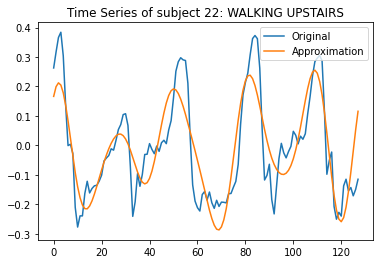

In [15]:
idx = X.index[0]
plt.plot(X.loc[idx], label='Original')
plt.plot(pd.DataFrame(ts_dft_inv, index=X.index).loc[idx], label='Approximation')
plt.title('Time Series of subject {}: {}'.format(df['individuals'].loc[idx], df['label'].loc[idx].replace('_', ' ')))
plt.legend()

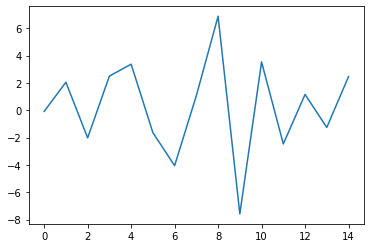

In [16]:
plt.plot(pd.DataFrame(ts_dft[:,1:], index=X.index).loc[idx]) #non significant as they are just not plottable coefficient

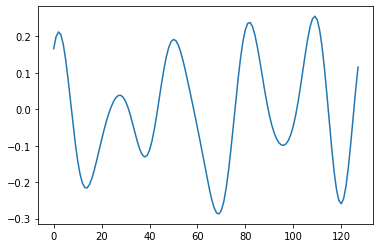

In [17]:
plt.plot(pd.DataFrame(ts_dft_inv, index=X.index).loc[idx])

In [18]:
approximated_df = pd.concat((df[['label', 'individuals']].loc[X.index], pd.DataFrame(ts_dft, index=X.index)), axis=1)
approximated_df

,label,individuals,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4531,WALKING_UPSTAIRS,22,-1.168852,-0.085870,2.047614,-2.025408,2.497303,3.368107,-1.637545,-4.057439,1.066534,6.876780,-7.589789,3.530912,-2.468259,1.153257,-1.260075,2.460886
6718,LAYING,29,74.296382,-0.026335,0.136708,0.041114,-0.003523,-0.011755,0.093766,-0.015358,0.091034,0.025347,0.065720,-0.078498,0.032231,0.033703,0.019689,-0.046222
4254,SITTING,21,-10.542654,0.026462,0.197984,0.181827,0.078771,0.080541,-0.006833,0.037098,0.035743,0.001046,-0.085234,0.102607,-0.028582,0.014003,0.065147,-0.031800
1790,SITTING,8,54.347453,0.037182,0.133996,0.117647,0.059392,0.007829,-0.001524,-0.095524,0.041901,-0.110578,0.060477,0.032966,0.070072,-0.109931,0.083520,0.045593
334,WALKING_DOWNSTAIRS,1,-16.185517,-1.782311,-0.862667,-3.705582,-6.934184,1.800058,1.442277,3.622128,1.831939,-0.214598,-0.138878,-1.130834,-0.081986,-1.041214,-0.278489,-0.338593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,SITTING,17,-14.523363,0.182891,0.092167,0.075150,0.020632,0.155438,0.011004,0.014658,0.013131,0.064807,-0.011484,-0.034599,0.026570,-0.011357,0.086118,-0.088191
5997,WALKING,27,-3.458096,-0.078256,0.073157,1.060318,-0.091878,-1.095331,-1.724140,-2.272330,-3.491655,1.535413,5.559207,0.059436,1.719896,-0.051276,1.071782,-0.764764
1070,LAYING,6,-4.465441,0.132156,-0.127768,0.013685,0.126441,-0.062813,-0.083846,-0.040997,0.180815,0.081001,-0.130631,-0.060283,0.061797,-0.102060,-0.087448,0.104810
4027,SITTING,21,-32.504243,0.079673,0.099955,0.060899,-0.004959,0.093749,-0.003813,-0.047840,0.024800,-0.038535,0.002678,0.006927,0.047234,0.090878,0.028140,0.023577


In [19]:
scaler_MV = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler_MV.fit_transform(X.loc[X.index[0]].values.reshape(1, -1)).ravel()
for i in X.index[1:]:
    ts = np.vstack([ts, scaler_MV.fit_transform(X.loc[i].values.reshape(1, -1)).ravel()])
    
ts = pd.DataFrame(ts)
ts = X.reset_index(drop = True) #because honestly the MeanVariance scaler lower too much the classification performances

In [20]:
ts

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.262741,0.316917,0.366231,0.384051,0.304105,0.136227,-0.000928,0.003682,-0.027590,-0.210649,...,-0.250839,-0.227603,-0.240337,-0.137529,-0.115026,-0.154609,-0.143362,-0.171437,-0.149755,-0.115161
1,0.575973,0.576778,0.578186,0.580357,0.580021,0.579104,0.577264,0.577110,0.578765,0.577051,...,0.584167,0.583830,0.584116,0.586320,0.590568,0.588911,0.586257,0.583616,0.575994,0.573930
2,-0.081905,-0.082446,-0.081776,-0.080899,-0.078631,-0.077907,-0.082832,-0.083408,-0.079008,-0.078934,...,-0.086273,-0.084826,-0.081588,-0.082008,-0.079454,-0.071268,-0.063460,-0.063269,-0.072551,-0.077171
3,0.425291,0.424616,0.421439,0.418298,0.418790,0.421319,0.421171,0.424750,0.425353,0.424395,...,0.430409,0.430575,0.430682,0.430368,0.430863,0.431454,0.431544,0.428504,0.422287,0.423384
4,-0.197834,-0.241258,-0.246753,-0.169554,-0.149789,-0.125964,-0.107714,-0.114576,-0.099677,-0.057707,...,-0.182278,-0.224578,-0.300547,-0.285264,-0.229928,-0.077318,-0.021791,-0.089411,-0.130486,-0.165791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,-0.111355,-0.106974,-0.110801,-0.114352,-0.112389,-0.113874,-0.115263,-0.109589,-0.102957,-0.104351,...,-0.111961,-0.109463,-0.106977,-0.104688,-0.101425,-0.101124,-0.101693,-0.102980,-0.103245,-0.102699
346,-0.319760,-0.258794,-0.105785,0.118280,0.015320,-0.162744,-0.058012,-0.046462,-0.070708,0.029644,...,-0.034934,-0.036653,0.031661,0.018687,-0.001934,0.010450,0.005132,0.061760,0.061262,0.080736
347,-0.029072,-0.024992,-0.025821,-0.031664,-0.037174,-0.035755,-0.029281,-0.028988,-0.032028,-0.035861,...,-0.030955,-0.028342,-0.029043,-0.030871,-0.034372,-0.042257,-0.043049,-0.039974,-0.039358,-0.036348
348,-0.251040,-0.253362,-0.251386,-0.247775,-0.249156,-0.253912,-0.256188,-0.255666,-0.251132,-0.248938,...,-0.254565,-0.254264,-0.252386,-0.250085,-0.247526,-0.248575,-0.249136,-0.248184,-0.249984,-0.254968


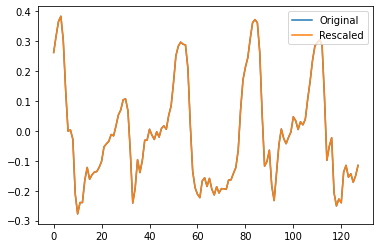

In [21]:
plt.plot(X.values[0], label='Original')
plt.plot(ts.loc[0], label='Rescaled')
plt.legend()

In [22]:
# FOURIER transform
n_coefs = 16
dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft = dft.fit_transform(ts)
ts_dft_inv = dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=ts.shape[1])

# PAA transform (and inverse transform) of the data
n_paa_segments = 15
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = pd.DataFrame(paa.fit_transform(ts.values).reshape(len(ts), n_paa_segments))
paa_dataset_inv = pd.DataFrame(paa.inverse_transform(ts_paa).reshape(len(ts), len(ts.columns)))

# SAX transform
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = pd.DataFrame(sax.fit_transform(ts).reshape(len(ts), n_paa_segments))
sax_dataset_inv = pd.DataFrame(sax.inverse_transform(ts_sax).reshape(len(ts), len(ts.columns)))

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 <a list of 6 Text major ticklabel objects>)

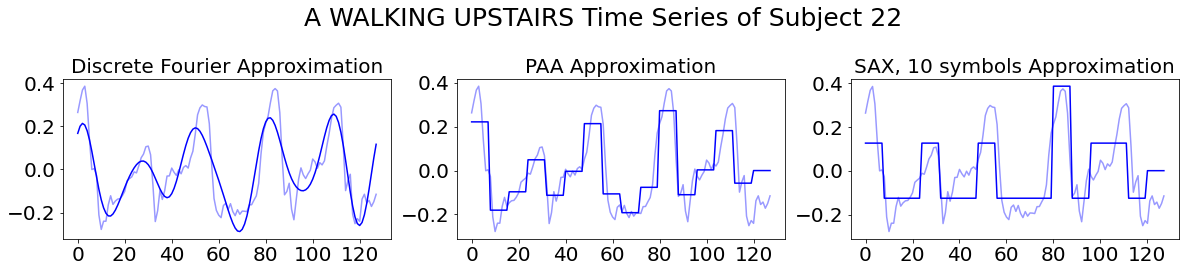

In [23]:
idxs = 0
plt.figure(figsize=(20,10))

plt.suptitle(t='A %s Time Series of Subject %s' % (approximated_df['label'].values[idxs].replace('_',' '), approximated_df['individuals'].values[idxs]), fontsize=25)
plt.subplot(3, 3, 1) # PAA
plt.plot(ts.loc[idxs].ravel(), "b-", alpha=0.4)
plt.plot(pd.DataFrame(ts_dft_inv).loc[idxs].ravel(), "b-")
plt.title("Discrete Fourier Approximation", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(3, 3, 2) # PAA
plt.plot(ts.loc[idxs].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv.loc[idxs].ravel(), "b-")
plt.title("PAA Approximation", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(3, 3, 3)  # SAX
plt.plot(ts.loc[idxs].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv.loc[idxs].ravel(), "b-")
plt.title("SAX, %d symbols Approximation" % (n_sax_symbols), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

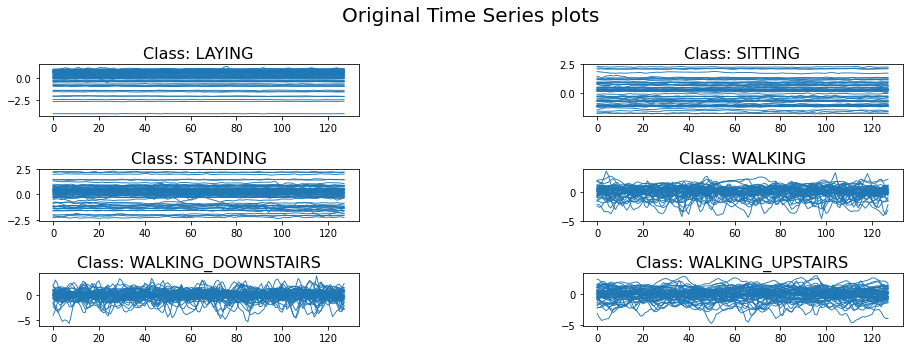

In [24]:
plt.figure()
for i, classe in enumerate(sorted(approximated_df['label'].unique())):
    plt.subplot(len(approximated_df['label'].unique()), 6//3, i + 1)
    to_plot_inside = X[approximated_df['label'].values == classe].values
    for x in ((to_plot_inside - to_plot_inside.mean())/to_plot_inside.std()):
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    
plt.tight_layout()
plt.subplots_adjust(top=8, bottom=6, left=0, right=2, hspace=1)
plt.suptitle(t='Original Time Series plots', x=1, y=8.2, fontsize=20)
plt.show()

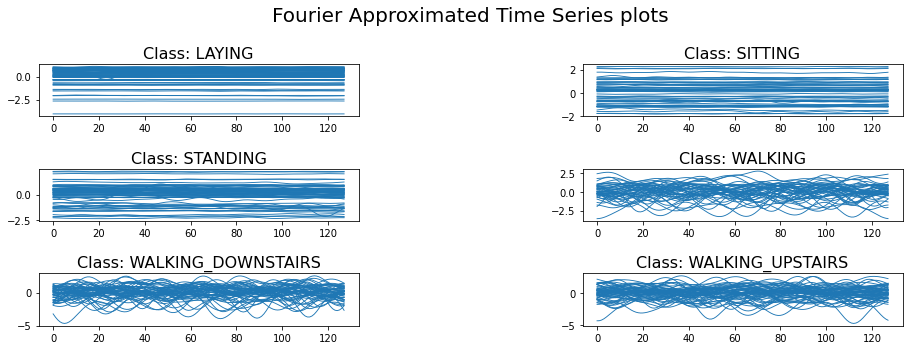

In [25]:
plt.figure()
for i, classe in enumerate(sorted(approximated_df['label'].unique())):
    plt.subplot(len(approximated_df['label'].unique()), 6//3, i + 1)
    to_plot_inside = ts_dft_inv[approximated_df['label'].values == classe]
    for x in ((to_plot_inside - to_plot_inside.mean())/to_plot_inside.std()):
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    
plt.tight_layout()
plt.subplots_adjust(top=8, bottom=6, left=0, right=2, hspace=1)
plt.suptitle(t='Fourier Approximated Time Series plots', x=1, y=8.2, fontsize=20)
plt.show()

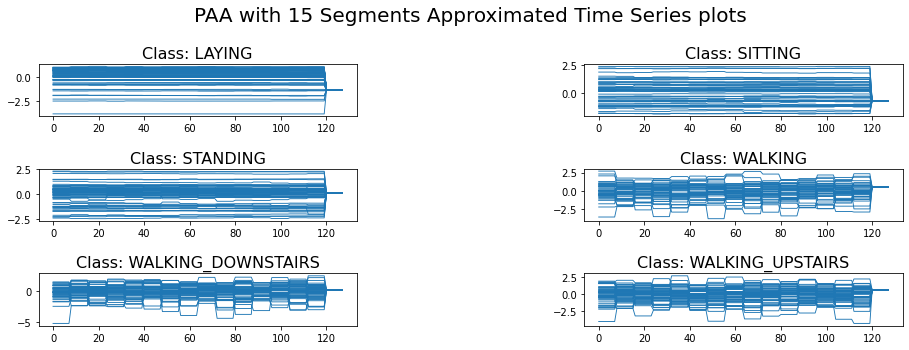

In [26]:
plt.figure()
for i, classe in enumerate(sorted(approximated_df['label'].unique())):
    plt.subplot(len(approximated_df['label'].unique()), 6//3, i + 1)
    to_plot_inside = paa_dataset_inv[approximated_df['label'].values == classe].values
    for x in ((to_plot_inside - to_plot_inside.mean())/to_plot_inside.std()):
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    
plt.tight_layout()
plt.subplots_adjust(top=8, bottom=6, left=0, right=2, hspace=1)
plt.suptitle(t='PAA with %d Segments Approximated Time Series plots' % n_paa_segments, x=1, y=8.2, fontsize=20)
plt.show()

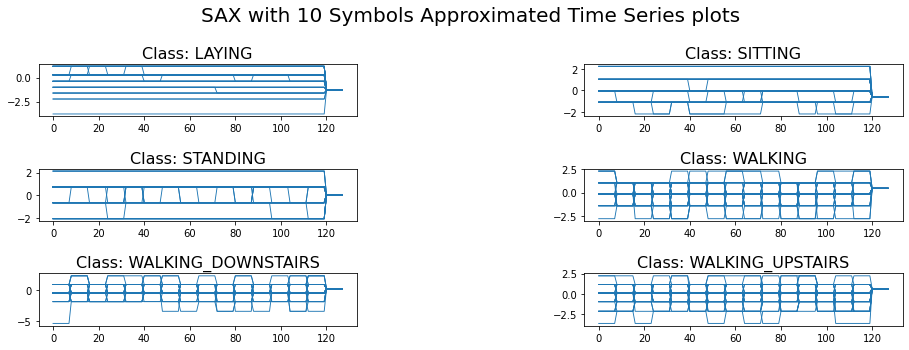

In [27]:
plt.figure()
for i, classe in enumerate(sorted(approximated_df['label'].unique())):
    plt.subplot(len(approximated_df['label'].unique()), 6//3, i + 1)
    to_plot_inside = sax_dataset_inv[approximated_df['label'].values == classe].values
    for x in ((to_plot_inside - to_plot_inside.mean())/to_plot_inside.std()):
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    
plt.tight_layout()
plt.subplots_adjust(top=8, bottom=6, left=0, right=2, hspace=1)
plt.suptitle(t='SAX with %d Symbols Approximated Time Series plots' % n_sax_symbols, x=1, y=8.2, fontsize=20)
plt.show()

In [28]:
approx_val = approximated_df[[x for x in approximated_df.columns if x not in ['label', 'individuals']]].values

scaler_mM = TimeSeriesScalerMinMax()
approx_val = scaler_mM.fit_transform(approx_val).reshape(approx_val.shape[0], approx_val.shape[1])

#approx_val = scaler_mM.fit_transform(ts_sax).reshape(ts_paa.shape[0], ts_sax.shape[1])

original_X_scaled = scaler_mM.fit_transform(X).reshape(X.shape[0], X.shape[1])

## Classification of the approximations

DFT:

Results on the VALIDATION SET:
EUCLIDEAN is the metric of this subsection:
Accuracy 0.9523809523809523
F1-score [0.97109827 0.86486486]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        84
           1       1.00      0.76      0.86        21

    accuracy                           0.95       105
   macro avg       0.97      0.88      0.92       105
weighted avg       0.96      0.95      0.95       105

0.9203514739229024 AUC of WALKING UPSTAIRS

CITYBLOCK is the metric of this subsection:
Accuracy 0.9523809523809523
F1-score [0.97109827 0.86486486]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        84
           1       1.00      0.76      0.86        21

    accuracy                           0.95       105
   macro avg       0.97      0.88      0.92       105
weighted avg       0.96      0.95      0.95       105

0.9192176870748299 AUC of WALKING UPSTAIRS

DTW is the 

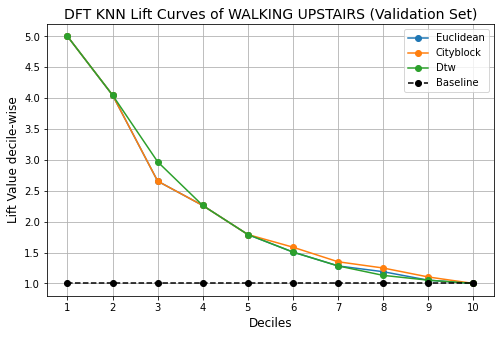



____________________________________________________________________

____________________________________________________________________


Results on the test set:
EUCLIDEAN is the metric of this subsection:
Accuracy 0.9142857142857143
F1-score [0.95016611 0.69387755]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       1.00      0.53      0.69        64

    accuracy                           0.91       350
   macro avg       0.95      0.77      0.82       350
weighted avg       0.92      0.91      0.90       350

0.85194493006993 AUC of WALKING UPSTAIRS
CITYBLOCK is the metric of this subsection:
Accuracy 0.9171428571428571
F1-score [0.95174709 0.70707071]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       1.00      0.55      0.71        64

    accuracy                           0.92       350
   macro avg       0.95      0.77   

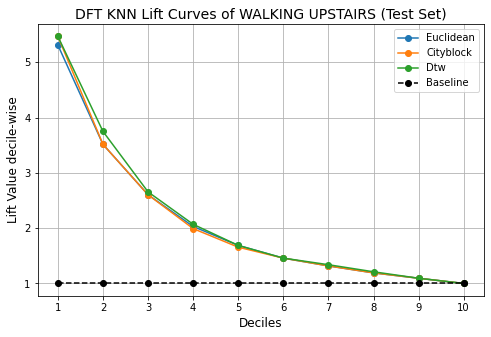



####################################################################


PAA:

Results on the VALIDATION SET:
EUCLIDEAN is the metric of this subsection:
Accuracy 0.9523809523809523
F1-score [0.97109827 0.86486486]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        84
           1       1.00      0.76      0.86        21

    accuracy                           0.95       105
   macro avg       0.97      0.88      0.92       105
weighted avg       0.96      0.95      0.95       105

0.9189342403628119 AUC of WALKING UPSTAIRS

CITYBLOCK is the metric of this subsection:
Accuracy 0.9523809523809523
F1-score [0.97109827 0.86486486]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        84
           1       1.00      0.76      0.86        21

    accuracy                           0.95       105
   macro avg       0.97      0.88      0.92       105
weighted avg       0.96      0.95    

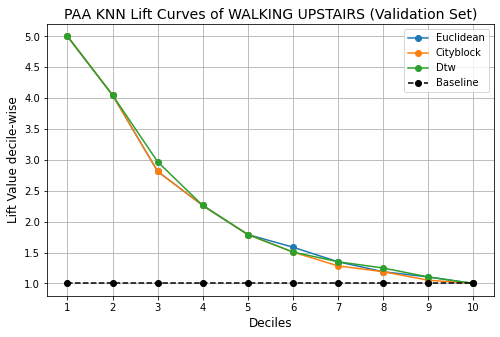



____________________________________________________________________

____________________________________________________________________


Results on the test set:
EUCLIDEAN is the metric of this subsection:
Accuracy 0.9142857142857143
F1-score [0.95016611 0.69387755]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       1.00      0.53      0.69        64

    accuracy                           0.91       350
   macro avg       0.95      0.77      0.82       350
weighted avg       0.92      0.91      0.90       350

0.8544307255244755 AUC of WALKING UPSTAIRS
CITYBLOCK is the metric of this subsection:
Accuracy 0.9142857142857143
F1-score [0.95016611 0.69387755]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       1.00      0.53      0.69        64

    accuracy                           0.91       350
   macro avg       0.95      0.77 

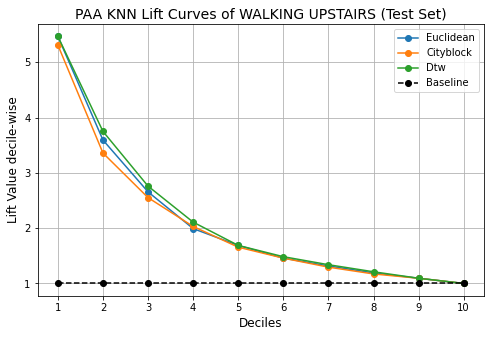



####################################################################


SAX:

Results on the VALIDATION SET:
EUCLIDEAN is the metric of this subsection:
Accuracy 0.9428571428571428
F1-score [0.96551724 0.83333333]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        84
           1       1.00      0.71      0.83        21

    accuracy                           0.94       105
   macro avg       0.97      0.86      0.90       105
weighted avg       0.95      0.94      0.94       105

0.9223356009070295 AUC of WALKING UPSTAIRS

CITYBLOCK is the metric of this subsection:
Accuracy 0.9428571428571428
F1-score [0.96551724 0.83333333]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        84
           1       1.00      0.71      0.83        21

    accuracy                           0.94       105
   macro avg       0.97      0.86      0.90       105
weighted avg       0.95      0.94    

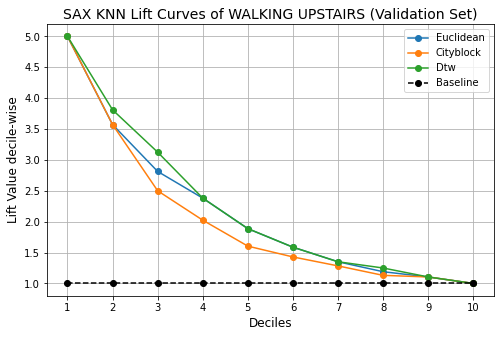



____________________________________________________________________

____________________________________________________________________


Results on the test set:
EUCLIDEAN is the metric of this subsection:
Accuracy 0.9114285714285715
F1-score [0.94859038 0.68041237]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       286
           1       1.00      0.52      0.68        64

    accuracy                           0.91       350
   macro avg       0.95      0.76      0.81       350
weighted avg       0.92      0.91      0.90       350

0.8473557692307693 AUC of WALKING UPSTAIRS
CITYBLOCK is the metric of this subsection:
Accuracy 0.9114285714285715
F1-score [0.94859038 0.68041237]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       286
           1       1.00      0.52      0.68        64

    accuracy                           0.91       350
   macro avg       0.95      0.76 

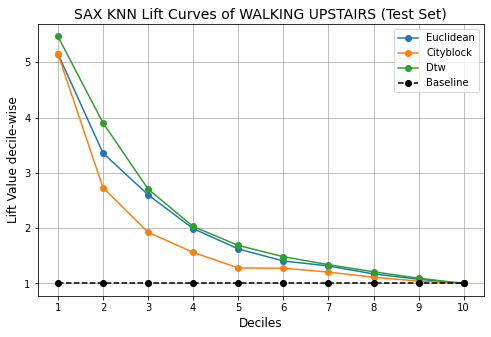



####################################################################




In [29]:
for approximation in ['dft', 'paa', 'sax']:
    print(approximation.upper()+':')
    print()
    ############ BUILDING THE TARGET VARIABLE IN SINGLE AND MULTICLASS ###############
    dict_back_remap = dict([(v, k) for k, v in remap_dict.items()])
    y_multi = [dict_back_remap.get(number, number) for number in approximated_df['label'].values]
    y_double = [x if (x == 5) or (x == 6) else 0 for x in y_multi]
    y = [1 if _ == 6 else 0 for _ in y_multi]

    #RESCALING WITH MINMAX THE APPROXIMATED TIME SERIES (WORST RESULTS AND I DIDN'T USE IT IN THE END)
    ts_dft_scaled = scaler_mM.fit_transform(ts_dft).reshape(ts_dft.shape[0], ts_dft.shape[1])
    ts_paa_scaled = scaler_mM.fit_transform(ts_paa).reshape(ts_paa.shape[0], ts_paa.shape[1])
    ts_sax_scaled = scaler_mM.fit_transform(ts_sax).reshape(ts_sax.shape[0], ts_sax.shape[1])

    #LOADING THE TEST SET
    X_test = Xdf_test.sample(n=number_of_records, random_state=42)
    indexes_to_consider = X_test.index
    X_test = X_test.values
    #X_test = scaler_MV.fit_transform(X_test).reshape(X_test.shape[0], X_test.shape[1]) #lower performances

    y_test_multi = [dict_back_remap.get(number, number) for number in df_test['label'].loc[indexes_to_consider].values.tolist()]
    y_test_double = [x if (x == 5) or (x == 6) else 0 for x in y_test_multi]
    y_test = [1 if _ == 6 else 0 for _ in y_test_multi]

    #SELECTING THE APPROXIMATION TO USE AND SETTING THE
    if approximation == 'dft':
        X_train, X_valid, y_train, y_valid = train_test_split(ts_dft, y, test_size=0.3, random_state=0)
        X_test = dft.fit_transform(X_test)
        #X_train, X_valid, X_test = X_train[:,1:], X_valid[:,1:], X_test[:,1:] #I used it to remove the first coefficient of the fourie transformation to see the results if they changed much
    elif approximation == 'paa':
        X_train, X_valid, y_train, y_valid = train_test_split(ts_paa, y, test_size=0.3, random_state=0)
        X_test = pd.DataFrame(paa.fit_transform(X_test).reshape(len(X_test), n_paa_segments))
        X_train, X_valid, X_test = X_train.values, X_valid.values, X_test.values
    elif approximation == 'sax':
        X_train, X_valid, y_train, y_valid = train_test_split(ts_sax, y, test_size=0.3, random_state=0)
        X_test = pd.DataFrame(paa.fit_transform(X_test).reshape(len(X_test), n_paa_segments))
        X_test = pd.DataFrame(sax.fit_transform(X_test).reshape(len(X_test), n_paa_segments))
        X_train, X_valid, X_test = X_train.values, X_valid.values, X_test.values

    #X_test = scaler_mM.fit_transform(X_test).reshape(X_test.shape[0], X_test.shape[1])

    #CLASSIFIYING
    print('Results on the VALIDATION SET:')
    test_results = []

    plt.figure(figsize=(8,5))

    for metric in ['euclidean', 'cityblock', 'dtw']:

        print(metric.upper(), 'is the metric of this subsection:')
        knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, metric=metric)
        knn.fit(X_train, y_train)

        y_valid_pred = knn.predict(X_valid)
        y_valid_score = knn.predict_proba(X_valid)

        plt.plot(np.arange(0,10,1), kds.metrics.decile_table(y_valid, y_valid_score[:,1], labels=False)['lift'].values, '-o', label=metric[0].upper()+metric[1:])

        print('Accuracy %s' % accuracy_score(y_valid, y_valid_pred))
        print('F1-score %s' % f1_score(y_valid, y_valid_pred, average=None))
        print(classification_report(y_valid, y_valid_pred))

        fpr, tpr, _ = roc_curve(y_valid, y_valid_score[:,1])

        print(auc(fpr, tpr), 'AUC of WALKING UPSTAIRS')
        print()

        y_pred = knn.predict(X_test)
        y_test_score = knn.predict_proba(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_test_score[:,1])

        roc_auc = auc(fpr, tpr)
        accuracy = 'Accuracy %s' % accuracy_score(y_test, y_pred)
        f1 = 'F1-score %s' % f1_score(y_test, y_pred, average=None)
        report = classification_report(y_test, y_pred)

        test_results.append((metric, accuracy, f1, report, roc_auc, y_test_score))

    plt.plot(np.arange(0,10,1), [1 for _ in range(10)], 'k--o', label='Baseline')
    plt.xticks(np.arange(0,10,1), np.arange(1,11,1), fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Deciles', fontsize=12)
    plt.ylabel('Lift Value decile-wise', fontsize=12)
    plt.title('{} KNN Lift Curves of WALKING UPSTAIRS (Validation Set)'.format(approximation.upper()), fontsize=14)
    plt.grid()
    plt.legend()
    plt.show()


    print('\n\n____________________________________________________________________')
    print('\n____________________________________________________________________\n\n')

    #JUST THE RESULTS GATHERED FOR THE TEST SET (IN ORDER TO SEPARATE THE PLOTS)
    print('Results on the test set:')
    plt.figure(figsize=(8,5))

    for metric, accuracy, f1, report, roc_auc, y_test_score in test_results:
        print(metric.upper(), 'is the metric of this subsection:')
        print(accuracy, f1, report, sep='\n')
        print(roc_auc, 'AUC of WALKING UPSTAIRS')

        plt.plot(np.arange(0,10,1), kds.metrics.decile_table(y_test, y_test_score[:,1], labels=False)['lift'].values, '-o', label=metric[0].upper()+metric[1:])


    plt.plot(np.arange(0,10,1), [1 for _ in range(10)], 'k--o', label='Baseline')
    plt.xticks(np.arange(0,10,1), np.arange(1,11,1), fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Deciles', fontsize=12)
    plt.ylabel('Lift Value decile-wise', fontsize=12)
    plt.title('{} KNN Lift Curves of WALKING UPSTAIRS (Test Set)'.format(approximation.upper()), fontsize=14)
    plt.grid()
    plt.legend()
    plt.show()

    print('\n\n####################################################################\n\n')

Accuracy 0.9523809523809523
F1-score [0.97109827 0.86486486]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        84
           1       1.00      0.76      0.86        21

    accuracy                           0.95       105
   macro avg       0.97      0.88      0.92       105
weighted avg       0.96      0.95      0.95       105

0.9390589569160998 AUC of WALKING UPSTAIRS



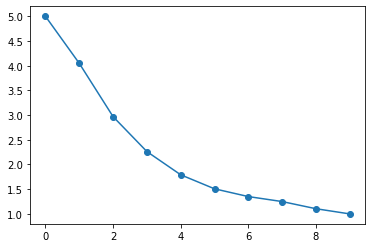

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X.values, y, test_size=0.3, random_state=0)
knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, metric=metric)
knn.fit(X_train, y_train)

y_valid_pred = knn.predict(X_valid)
y_valid_score = knn.predict_proba(X_valid)

plt.plot(np.arange(0,10,1), kds.metrics.decile_table(y_valid, y_valid_score[:,1], labels=False)['lift'].values, '-o', label=metric[0].upper()+metric[1:])

print('Accuracy %s' % accuracy_score(y_valid, y_valid_pred))
print('F1-score %s' % f1_score(y_valid, y_valid_pred, average=None))
print(classification_report(y_valid, y_valid_pred))
fpr, tpr, _ = roc_curve(y_valid, y_valid_score[:,1])

print(auc(fpr, tpr), 'AUC of WALKING UPSTAIRS')
print()


## Clustering

In [31]:
labels_for_X = approximated_df['label'] 

X_clust = approximated_df[[x for x in approximated_df.columns if x not in ['label', 'individuals']]].values
X_clust = X

km = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=5, random_state=42)
km.fit(X_clust)
print(km)
print(km.cluster_centers_.shape)

TimeSeriesKMeans(max_iter=5, n_clusters=6, random_state=42)
(6, 128, 1)


Text(0.5, 1.0, 'Mean Time Series per Label of Moving State')

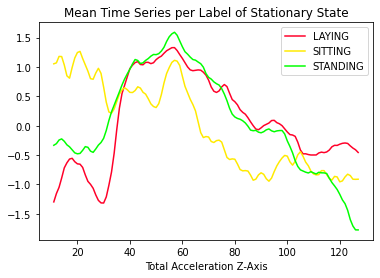

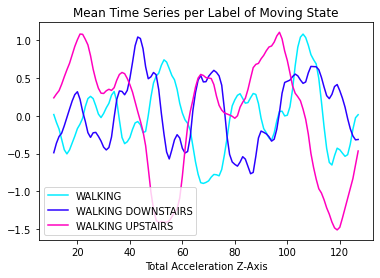

In [32]:
to_plot = []
for lab in sorted(labels_for_X.unique()):
    first = X[labels_for_X == lab].mean().values
    to_plot.append((first, lab))
    
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))

for n, (tms, lab) in enumerate(to_plot):
    if n == 3:
        plt.legend()
        plt.xlabel('Total Acceleration Z-Axis')
        plt.title('Mean Time Series per Label of Stationary State')
        plt.plot()
        plt.figure()
    c = next(color)
    tms = pd.Series(tms)
    plt.plot(((tms-tms.mean())/tms.std()).rolling(window=12).mean(), label = '{}'.format(lab.replace('_', ' ')), c=c)
    
plt.xlabel('Total Acceleration Z-Axis')
plt.legend()
plt.title('Mean Time Series per Label of Moving State')

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 <a list of 11 Text major ticklabel objects>)

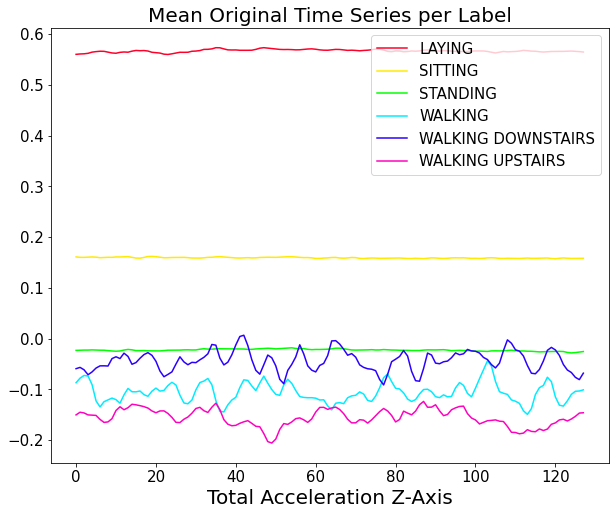

In [33]:
plt.figure(figsize=(10, 8))
to_plot = []
for lab in sorted(labels_for_X.unique()):
    first = X[labels_for_X == lab].mean().values
    to_plot.append((first, lab))
    
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))

for n, (tms, lab) in enumerate(to_plot):
    c = next(color)
    tms = pd.Series(tms)
    plt.plot((tms), label = '{}'.format(lab.replace('_', ' ')), c=c)
plt.legend(fontsize=15)
plt.title('Mean Original Time Series per Label', fontsize=20)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [34]:
to_plot2 = pd.DataFrame(np.squeeze(km.cluster_centers_))

In [35]:
to_plot2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.799274,0.800733,0.801341,0.802619,0.805980,0.807675,0.809549,0.809450,0.806430,0.803425,...,0.809411,0.809611,0.809551,0.809719,0.810091,0.811174,0.812044,0.811442,0.810179,0.808560
1,-0.195943,-0.186391,-0.181719,-0.186745,-0.188538,-0.195560,-0.197638,-0.194744,-0.196841,-0.191151,...,-0.177041,-0.170135,-0.185614,-0.202980,-0.208925,-0.198007,-0.177129,-0.168629,-0.172284,-0.179644
2,0.200017,0.196757,0.192239,0.196985,0.209061,0.210221,0.206576,0.204295,0.195261,0.192381,...,0.214779,0.205513,0.195164,0.190226,0.187882,0.190532,0.189242,0.189387,0.189225,0.188112
3,-0.408322,-0.417236,-0.432800,-0.447044,-0.455565,-0.465586,-0.474910,-0.472817,-0.442112,-0.403015,...,-0.422250,-0.429557,-0.442234,-0.437298,-0.428076,-0.418799,-0.428353,-0.453098,-0.443508,-0.416370
4,0.490198,0.489153,0.488001,0.489104,0.490258,0.489828,0.489362,0.490574,0.492067,0.491434,...,0.487547,0.488158,0.488825,0.489114,0.488726,0.488539,0.488296,0.488215,0.488767,0.489749
5,-0.000013,0.005175,0.008180,0.006287,0.000474,-0.002437,-0.003997,-0.004193,-0.005782,-0.007417,...,-0.008810,-0.003358,0.000798,0.004011,-0.001453,-0.014504,-0.019330,-0.016834,-0.015467,-0.011043


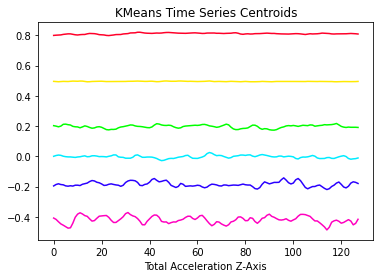

In [36]:
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))
{0:'red', 1:'yellow', 2:'green', 3:'cyan', 4:'blue', 5:'magenta'}

for lab in [0, 4, 2, 5, 1, 3]:
    ecce = X[km.labels_ == lab].mean()
    c = next(color)
    plt.plot(ecce, c=c)
    plt.title('KMeans Time Series Centroids')
    plt.xlabel('Total Acceleration Z-Axis')

In [37]:
for num, lab in zip([0, 2, 3, 5, 1, 4], ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']):
    print(lab)
    count_1 = 0
    for x in X[labels_for_X == lab].index:
        if x not in X[(km.labels_ == num)].index:
            count_1 += 1
            
    if count_1 == 0:
        print('The 2 clusters include all the time series of', lab.lower())
    else:
        print('The cluster did not include', count_1, 'time series')

    #reverse looking at the difference between clusters and originals
    count_2 = 0
    for x in X[(km.labels_ == num)].index:
        if x not in X[labels_for_X == lab].index:
            count_2 += 1

    if count_2 == 0:
        print('The original time series of', lab.lower(), 'include all the time series of the clustering')
    else:
        print('The original time sieries did not include', count_2, 'time series of the clustering')

    orig = len(X[labels_for_X == lab].index)
    clust = len(X[(km.labels_ == num)].index)
    print('ORIGINAL:', orig, '\nCLUSTER:', clust, '\nDIFF:', orig-clust, '\nERR_TOT:', count_1+count_2)
    print()
    #checking correspondence with the difference in length

LAYING
The cluster did not include 30 time series
The original time sieries did not include 2 time series of the clustering
ORIGINAL: 66 
CLUSTER: 38 
DIFF: 28 
ERR_TOT: 32

SITTING
The cluster did not include 39 time series
The original time sieries did not include 36 time series of the clustering
ORIGINAL: 60 
CLUSTER: 57 
DIFF: 3 
ERR_TOT: 75

STANDING
The cluster did not include 65 time series
The original time sieries did not include 28 time series of the clustering
ORIGINAL: 69 
CLUSTER: 32 
DIFF: 37 
ERR_TOT: 93

WALKING
The cluster did not include 28 time series
The original time sieries did not include 110 time series of the clustering
ORIGINAL: 45 
CLUSTER: 127 
DIFF: -82 
ERR_TOT: 138

WALKING_DOWNSTAIRS
The cluster did not include 39 time series
The original time sieries did not include 54 time series of the clustering
ORIGINAL: 53 
CLUSTER: 68 
DIFF: -15 
ERR_TOT: 93

WALKING_UPSTAIRS
The cluster did not include 57 time series
The original time sieries did not include 28 t

In [38]:
#### NOW WITH DTW DISTANCES ####

In [39]:
X_clust

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
4531,0.262741,0.316917,0.366231,0.384051,0.304105,0.136227,-0.000928,0.003682,-0.027590,-0.210649,...,-0.250839,-0.227603,-0.240337,-0.137529,-0.115026,-0.154609,-0.143362,-0.171437,-0.149755,-0.115161
6718,0.575973,0.576778,0.578186,0.580357,0.580021,0.579104,0.577264,0.577110,0.578765,0.577051,...,0.584167,0.583830,0.584116,0.586320,0.590568,0.588911,0.586257,0.583616,0.575994,0.573930
4254,-0.081905,-0.082446,-0.081776,-0.080899,-0.078631,-0.077907,-0.082832,-0.083408,-0.079008,-0.078934,...,-0.086273,-0.084826,-0.081588,-0.082008,-0.079454,-0.071268,-0.063460,-0.063269,-0.072551,-0.077171
1790,0.425291,0.424616,0.421439,0.418298,0.418790,0.421319,0.421171,0.424750,0.425353,0.424395,...,0.430409,0.430575,0.430682,0.430368,0.430863,0.431454,0.431544,0.428504,0.422287,0.423384
334,-0.197834,-0.241258,-0.246753,-0.169554,-0.149789,-0.125964,-0.107714,-0.114576,-0.099677,-0.057707,...,-0.182278,-0.224578,-0.300547,-0.285264,-0.229928,-0.077318,-0.021791,-0.089411,-0.130486,-0.165791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,-0.111355,-0.106974,-0.110801,-0.114352,-0.112389,-0.113874,-0.115263,-0.109589,-0.102957,-0.104351,...,-0.111961,-0.109463,-0.106977,-0.104688,-0.101425,-0.101124,-0.101693,-0.102980,-0.103245,-0.102699
5997,-0.319760,-0.258794,-0.105785,0.118280,0.015320,-0.162744,-0.058012,-0.046462,-0.070708,0.029644,...,-0.034934,-0.036653,0.031661,0.018687,-0.001934,0.010450,0.005132,0.061760,0.061262,0.080736
1070,-0.029072,-0.024992,-0.025821,-0.031664,-0.037174,-0.035755,-0.029281,-0.028988,-0.032028,-0.035861,...,-0.030955,-0.028342,-0.029043,-0.030871,-0.034372,-0.042257,-0.043049,-0.039974,-0.039358,-0.036348
4027,-0.251040,-0.253362,-0.251386,-0.247775,-0.249156,-0.253912,-0.256188,-0.255666,-0.251132,-0.248938,...,-0.254565,-0.254264,-0.252386,-0.250085,-0.247526,-0.248575,-0.249136,-0.248184,-0.249984,-0.254968


In [40]:
labels_for_X = approximated_df['label'] 

km = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=5, random_state=42)
km.fit(X_clust)
print(km)
print(km.cluster_centers_.shape)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=6, random_state=42)
(6, 128, 1)


[]

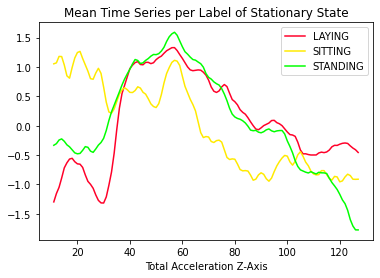

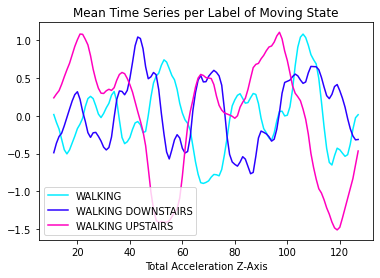

In [41]:
to_plot = []
for lab in sorted(labels_for_X.unique()):
    first = X[labels_for_X == lab].mean().values
    to_plot.append((first, lab))
    
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))

for n, (tms, lab) in enumerate(to_plot):
    if n == 3:
        plt.legend()
        plt.xlabel('Total Acceleration Z-Axis')
        plt.title('Mean Time Series per Label of Stationary State')
        plt.plot()
        plt.figure()
    c = next(color)
    tms = pd.Series(tms)
    plt.plot(((tms-tms.mean())/tms.std()).rolling(window=12).mean(), label = '{}'.format(lab.replace('_', ' ')), c=c)
    
plt.xlabel('Total Acceleration Z-Axis')
plt.legend()
plt.title('Mean Time Series per Label of Moving State')
plt.plot()

(-0.5, 0.9)

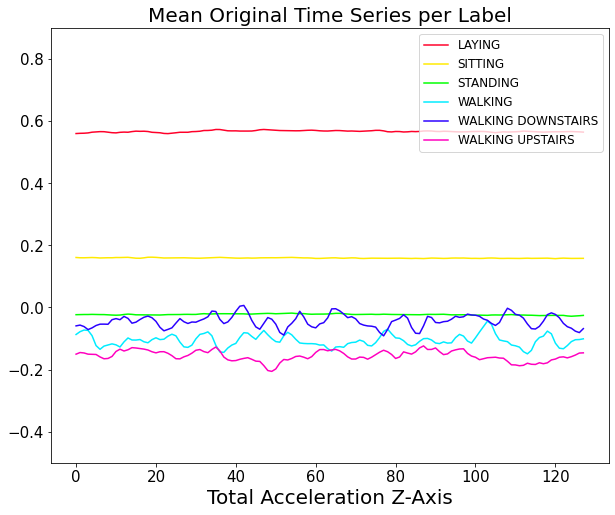

In [42]:
plt.figure(figsize=(10,8))
to_plot = []
for lab in sorted(labels_for_X.unique()):
    first = X[labels_for_X == lab].mean().values
    to_plot.append((first, lab))
    
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))

for n, (tms, lab) in enumerate(to_plot):
    c = next(color)
    tms = pd.Series(tms)
    plt.plot((tms), label = '{}'.format(lab.replace('_', ' ')), c=c)
plt.legend(fontsize=12)
plt.title('Mean Original Time Series per Label', fontsize=20)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5, 0.9)

In [43]:
to_plot2 = pd.DataFrame(np.squeeze(km.cluster_centers_))

In [44]:
to_plot2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.822200,0.793498,0.784083,0.784598,0.657990,0.791839,0.810518,0.798830,0.796718,0.796626,...,0.794554,0.794377,0.794340,0.796785,0.862939,0.799664,0.796794,0.800155,0.818635,0.805447
1,0.005854,-0.263116,-0.195098,-0.158932,-0.170729,-0.116337,-0.029509,-0.153783,-0.196588,-0.178358,...,-0.138970,-0.076447,-0.163593,-0.175029,-0.213947,-0.257275,-0.388144,-0.199502,-0.016590,-0.124175
2,0.470084,0.445406,0.426420,0.469724,0.474809,0.474088,0.473255,0.473929,0.474478,0.474366,...,0.468955,0.470180,0.470507,0.470613,0.470497,0.469829,0.428363,0.466733,0.445603,0.464305
3,0.111356,0.216227,0.232804,0.311173,0.222575,0.124464,0.193915,0.202200,0.210148,0.248986,...,0.208591,0.206913,0.207583,0.170325,0.040977,0.137326,0.213367,0.230465,0.307660,0.113195
4,-0.449192,-0.181651,-0.370179,-0.464682,-0.461991,-0.473595,-0.472724,-0.516179,-0.717049,-0.522216,...,-0.292816,-0.410559,-0.584021,-0.393524,-0.200006,-0.358996,-0.343366,-0.305380,-0.333473,-0.522259
5,0.009974,0.143251,0.028579,-0.005016,-0.076976,-0.004267,0.006661,0.065873,0.007458,0.005039,...,0.009182,0.009184,0.009169,0.009169,0.007934,-0.007460,-0.058993,-0.025710,0.010378,0.078538


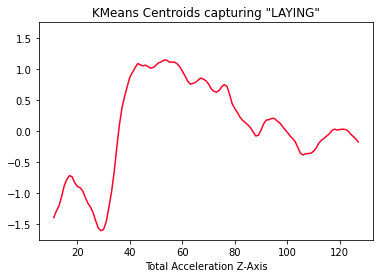

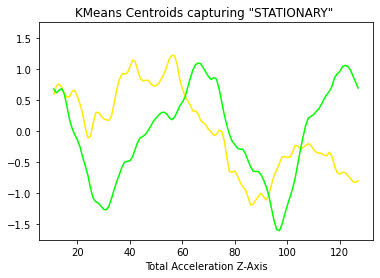

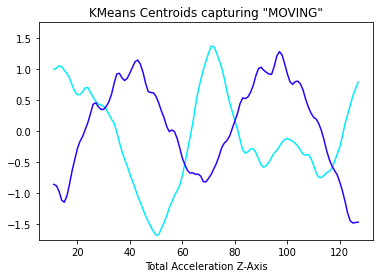

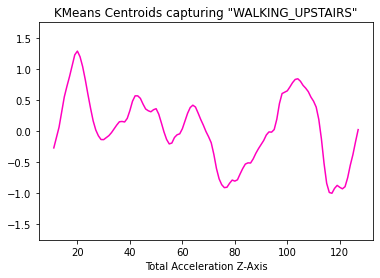

In [45]:
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))

for lab in [0, 2, 3, 5, 1, 4]:
    ecce = X[km.labels_ == lab].mean()
    c = next(color)
    plt.plot(((ecce-ecce.mean())/ecce.std()).rolling(window=12).mean(), c=c)
    plt.ylim(-1.75, 1.75)
    plt.title('KMeans Time Series Centroids capturing WALKING UP or DOWN')
    plt.xlabel('Total Acceleration Z-Axis')
    if lab == 0:
        plt.title('KMeans Centroids capturing "LAYING"')
        plt.show()
    if lab == 3:
        plt.title('KMeans Centroids capturing "STATIONARY" ')
        plt.show()
    if lab == 1:
        plt.title('KMeans Centroids capturing "MOVING"')
        plt.show()
    if lab == 4:
        plt.title('KMeans Centroids capturing "WALKING_UPSTAIRS"')
        plt.show()

(-0.5, 0.9)

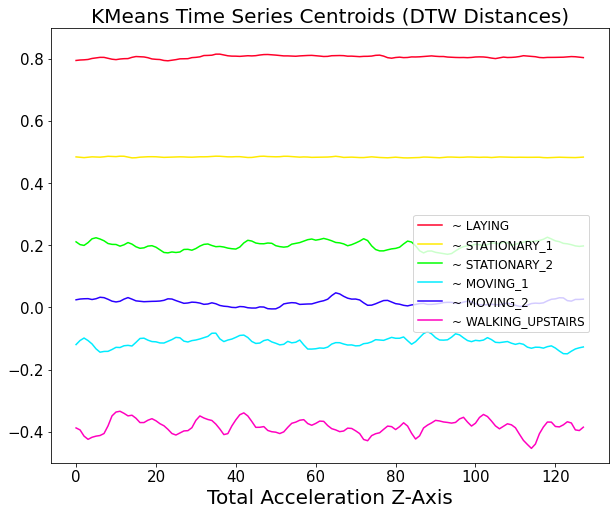

In [46]:
plt.figure(figsize=(10, 8))
color = iter(cm.gist_rainbow(np.linspace(0, 1, 6)))

for lab, info in zip([0, 2, 3, 1, 5, 4], ['~ LAYING', '~ STATIONARY_1', '~ STATIONARY_2', '~ MOVING_1', '~ MOVING_2', '~ WALKING_UPSTAIRS']):
    ecce = X[km.labels_ == lab].mean()
    c = next(color)
    plt.plot(ecce, c=c, label=info)
    plt.title('KMeans Time Series Centroids (DTW Distances)', fontsize=20)
plt.legend(loc=(0.65, 0.3), fontsize=12)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5, 0.9)

In [47]:
for num, lab in zip([0, 2, 3, 1, 5, 4], ['LAYING', 'SITTING', 'STANDING', 'WALKING_DOWNSTAIRS', 'WALKING', 'WALKING_UPSTAIRS']):
    print(lab)
    count_1 = 0
    for x in X[labels_for_X == lab].index:
        if x not in X[(km.labels_ == num)].index:
            count_1 += 1
            
    if count_1 == 0:
        print('The cluster include all the time series of', lab.lower())
    else:
        print('The cluster did not include', count_1, 'time series')

    #reverse looking at the difference between clusters and originals
    count_2 = 0
    for x in X[(km.labels_ == num)].index:
        if x not in X[labels_for_X == lab].index:
            count_2 += 1

    if count_2 == 0:
        print('The original time series of', lab.lower(), 'include all the time series of the clustering')
    else:
        print('The original time sieries did not include', count_2, 'time series of the clustering')

    orig = len(X[labels_for_X == lab].index)
    clust = len(X[(km.labels_ == num)].index)
    print('ORIGINAL:', orig, '\nCLUSTER:', clust, '\nDIFF:', orig-clust, '\nERR_TOT:', count_1+count_2)
    print()
    #checking correspondence with the difference in length

LAYING
The cluster did not include 30 time series
The original time sieries did not include 3 time series of the clustering
ORIGINAL: 66 
CLUSTER: 39 
DIFF: 27 
ERR_TOT: 33

SITTING
The cluster did not include 50 time series
The original time sieries did not include 18 time series of the clustering
ORIGINAL: 60 
CLUSTER: 28 
DIFF: 32 
ERR_TOT: 68

STANDING
The cluster did not include 60 time series
The original time sieries did not include 43 time series of the clustering
ORIGINAL: 69 
CLUSTER: 52 
DIFF: 17 
ERR_TOT: 103

WALKING_DOWNSTAIRS
The cluster did not include 25 time series
The original time sieries did not include 76 time series of the clustering
ORIGINAL: 53 
CLUSTER: 104 
DIFF: -51 
ERR_TOT: 101

WALKING
The cluster did not include 35 time series
The original time sieries did not include 76 time series of the clustering
ORIGINAL: 45 
CLUSTER: 86 
DIFF: -41 
ERR_TOT: 111

WALKING_UPSTAIRS
The cluster did not include 38 time series
The original time sieries did not include 22

In [48]:
lab1, lab2 = 'SITTING', 'STANDING'
num1, num2 = 2, 3

count_1 = 0
for x in X[(labels_for_X == lab1) | (labels_for_X == lab2)].index:
    if x not in X[(km.labels_ == num1) | (km.labels_ == num2)].index:
        count_1 += 1

if count_1 == 0:
    print('The cluster include all the time series')
else:
    print('The cluster did not include', count_1, 'time series')

#reverse looking at the difference between clusters and originals
count_2 = 0
for x in X[(km.labels_ == num1) | (km.labels_ == num2)].index:
    if x not in X[(labels_for_X == lab1) | (labels_for_X == lab2)].index:
        count_2 += 1

if count_2 == 0:
    print('The original time series include all the time series of the clustering')
else:
    print('The original time sieries did not include', count_2, 'time series of the clustering')

orig = len(X[(labels_for_X == lab1) | (labels_for_X == lab2)].index)
clust = len(X[(km.labels_ == num1) | (km.labels_ == num2)].index)
print('ORIGINAL:', orig, '\nCLUSTER:', clust, '\nDIFF:', orig-clust, '\nERR_TOT:', count_1+count_2)
print()
#checking correspondence with the difference in length

The cluster did not include 88 time series
The original time sieries did not include 39 time series of the clustering
ORIGINAL: 129 
CLUSTER: 80 
DIFF: 49 
ERR_TOT: 127



In [49]:
lab1, lab2 = 'WALKING', 'WALKING_DOWNSTAIRS'
num1, num2 = 5, 1

count_1 = 0
for x in X[(labels_for_X == lab1) | (labels_for_X == lab2)].index:
    if x not in X[(km.labels_ == num1) | (km.labels_ == num2)].index:
        count_1 += 1

if count_1 == 0:
    print('The cluster include all the time series')
else:
    print('The cluster did not include', count_1, 'time series')

#reverse looking at the difference between clusters and originals
count_2 = 0
for x in X[(km.labels_ == num1) | (km.labels_ == num2)].index:
    if x not in X[(labels_for_X == lab1) | (labels_for_X == lab2)].index:
        count_2 += 1

if count_2 == 0:
    print('The original time series include all the time series of the clustering')
else:
    print('The original time sieries did not include', count_2, 'time series of the clustering')

orig = len(X[(labels_for_X == lab1) | (labels_for_X == lab2)].index)
clust = len(X[(km.labels_ == num1) | (km.labels_ == num2)].index)
print('ORIGINAL:', orig, '\nCLUSTER:', clust, '\nDIFF:', orig-clust, '\nERR_TOT:', count_1+count_2)
print()
#checking correspondence with the difference in length

The cluster did not include 30 time series
The original time sieries did not include 122 time series of the clustering
ORIGINAL: 98 
CLUSTER: 190 
DIFF: -92 
ERR_TOT: 152



## Shapelets

In [50]:
Xv = X.values

In [51]:
n_ts, ts_sz = Xv.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 350
ts_sz 128
n_classes 2
shapelet_sizes {12: 4}


In [52]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1, scale=False)

/usr/local/lib/python3.7/dist-packages/tslearn/shapelets/shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


In [53]:
shp_clf.fit(Xv, y)

Epoch 1/200
2/2 [==============================] - 1s 11ms/step - loss: 0.7809 - binary_accuracy: 0.1600 - binary_crossentropy: 0.7774
Epoch 2/200
2/2 [==============================] - 0s 11ms/step - loss: 0.7780 - binary_accuracy: 0.1600 - binary_crossentropy: 0.7746
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 0.7751 - binary_accuracy: 0.1686 - binary_crossentropy: 0.7717
Epoch 4/200
2/2 [==============================] - 0s 10ms/step - loss: 0.7722 - binary_accuracy: 0.1829 - binary_crossentropy: 0.7689
Epoch 5/200
2/2 [==============================] - 0s 11ms/step - loss: 0.7694 - binary_accuracy: 0.1971 - binary_crossentropy: 0.7661
Epoch 6/200
2/2 [==============================] - 0s 11ms/step - loss: 0.7666 - binary_accuracy: 0.2143 - binary_crossentropy: 0.7633
Epoch 7/200
2/2 [==============================] - 0s 11ms/step - loss: 0.7638 - binary_accuracy: 0.2286 - binary_crossentropy: 0.7606
Epoch 8/200
2/2 [==============================] - 0s 1

LearningShapelets(max_iter=200, n_shapelets_per_size={12: 4}, verbose=1,
                  weight_regularizer=0.01)

In [54]:
predicted_labels = shp_clf.predict(Xv)
print("Correct classification rate:", accuracy_score(y, predicted_labels))

2/2 [==============================] - 0s 8ms/step
Correct classification rate: 0.8114285714285714


In [55]:
predicted_locations = shp_clf.locate(Xv)

2/2 [==============================] - 0s 8ms/step


In [56]:
approximated_df.reset_index().index[approximated_df['label'] == 'WALKING_UPSTAIRS']

Int64Index([  0,   7,  12,  23,  47,  66,  84,  88, 100, 115, 120, 121, 122,
            127, 128, 130, 131, 140, 144, 148, 153, 158, 166, 168, 170, 195,
            201, 207, 210, 211, 215, 219, 225, 230, 236, 237, 239, 240, 244,
            245, 252, 253, 266, 269, 279, 283, 297, 298, 301, 303, 305, 310,
            311, 316, 317, 339, 340],
           dtype='int64')

(array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <a list of 11 Text major ticklabel objects>)

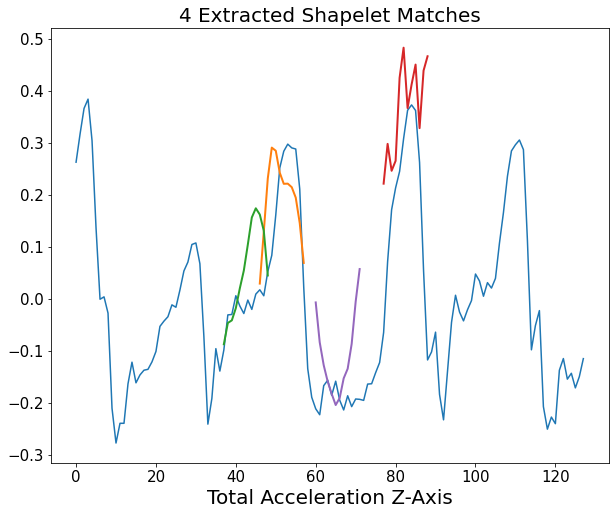

In [57]:
plt.figure(figsize=(10,8))
ts_id = 0
n_shapelets = sum(shapelet_sizes.values())
plt.title("{} Extracted Shapelet Matches".format(n_shapelets), fontsize=20)

shapelets_adjusted = np.array([shp_clf.shapelets_[n].ravel() for n in range(4)])
scostamento = 0.2
scale_shape = TimeSeriesScalerMinMax([Xv[ts_id].min()+scostamento, Xv[ts_id].max()-scostamento]).fit_transform(shapelets_adjusted)

plt.plot(Xv[ts_id].ravel())
for idx_shp, shp in enumerate(scale_shape):
    shp = shp + shapelets_adjusted[idx_shp].mean()*0.4
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [58]:
new_X = shp_clf.transform(Xv)

X_test = Xdf_test.sample(n=number_of_records, random_state=42).values
X_test = shp_clf.transform(X_test)
y_test = [1 if _ == 6 else 0 for _ in y_test_multi]


X_train, X_valid, y_train, y_valid = train_test_split(new_X, y, test_size=0.3, random_state=0)

2/2 [==============================] - 0s 9ms/step


In [59]:
for clf in [DecisionTreeClassifier(max_depth=8, random_state=42), KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform'), KNeighborsClassifier(n_neighbors=5, metric='dtw', weights='uniform'), KNeighborsClassifier(n_neighbors=5, metric='dtw_sakoechiba', weights='uniform'), KNeighborsClassifier(n_neighbors=5, metric='dtw_itakura', weights='uniform')]:
    classifier_str = str(clf)[:str(clf).find('(')]
    print(classifier_str, end=' ')
    if classifier_str != 'DecisionTreeClassifier':
        print('Metric =', str(clf)[str(clf).find('metric=')+len('metric='):str(clf).rfind(', weights')], end=' ')
    print()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))


    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    print(auc(fpr, tpr))
    print()

DecisionTreeClassifier 
Accuracy 0.8971428571428571
F1-score [0.93959732 0.65384615]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       286
           1       0.85      0.53      0.65        64

    accuracy                           0.90       350
   macro avg       0.88      0.76      0.80       350
weighted avg       0.89      0.90      0.89       350

0.8518356643356643

KNeighborsClassifier Metric = 'euclidean', n_neighbors=5 
Accuracy 0.9114285714285715
F1-score [0.94859038 0.68041237]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       286
           1       1.00      0.52      0.68        64

    accuracy                           0.91       350
   macro avg       0.95      0.76      0.81       350
weighted avg       0.92      0.91      0.90       350

0.8902972027972028

KNeighborsClassifier Metric = 'dtw', n_neighbors=5 
Accuracy 0.9142857142857143
F1-score [0.95016611 0

## Matrix Profile

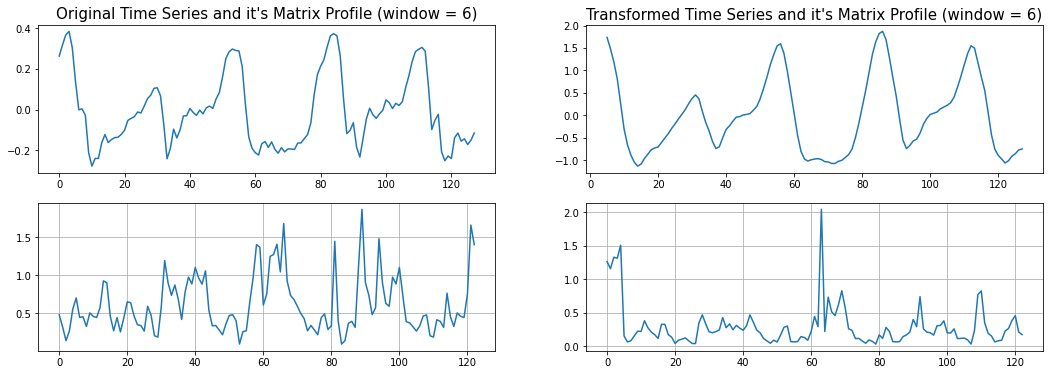

In [60]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

w = 6

plt.figure(figsize=(18,6))
plt.subplot(2, 2, 1)
plotting = X.loc[X.index[ts_id]]
plt.plot(plotting)
plt.title("Original Time Series and it's Matrix Profile (window = {})".format(w), fontsize=15)

mp, mpi = matrixProfile.stomp(plotting.values, w)

plt.subplot(2, 2, 3)
plt.plot(mp)
plt.grid()

plt.subplot(2, 2, 2)
plotting2 = ((plotting - plotting.mean())/plotting.std()).rolling(w).mean()
plt.plot(plotting2)
plt.title("Transformed Time Series and it's Matrix Profile (window = {})".format(w), fontsize=15)

mp2, mpi2 = matrixProfile.stomp(plotting2.values, w)

plt.subplot(2, 2, 4)
plt.plot(mp2)
plt.grid()
plt.show()

## Motif Discovery

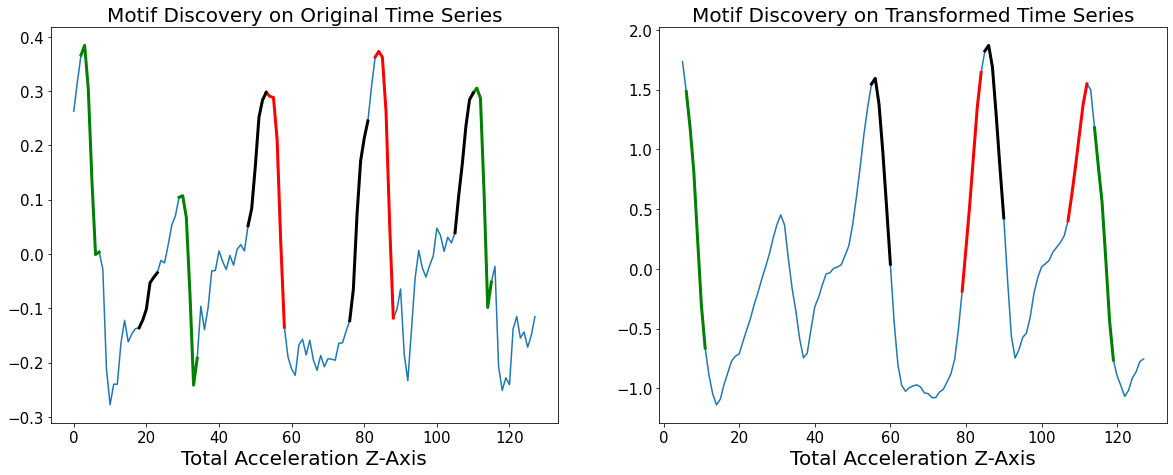

In [61]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

plt.figure(figsize=(20, 16))
plt.subplot(2,2,1)
mo, mod  = motifs.motifs(plotting.values, (mp, mpi), max_motifs=6)

plt.plot(plotting)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = plotting.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.title('Motif Discovery on Original Time Series', fontsize=20)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

mo, mod  = motifs.motifs(plotting2.values, (mp2, mpi2), max_motifs=6)

plt.subplot(2,2,2)
plt.plot(plotting2)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = plotting2.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.title('Motif Discovery on Transformed Time Series', fontsize=20)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

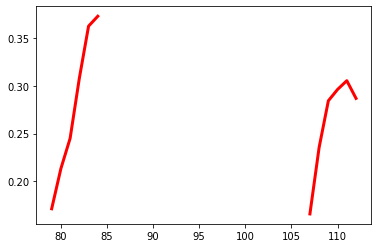

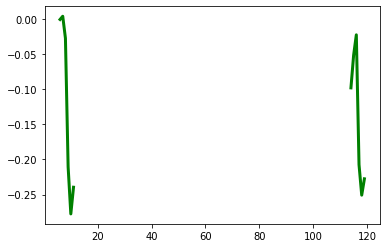

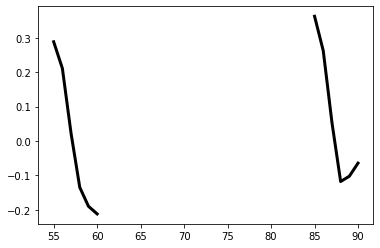

In [62]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = plotting.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

## Anomaly Discovery

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 9 Text major ticklabel objects>)

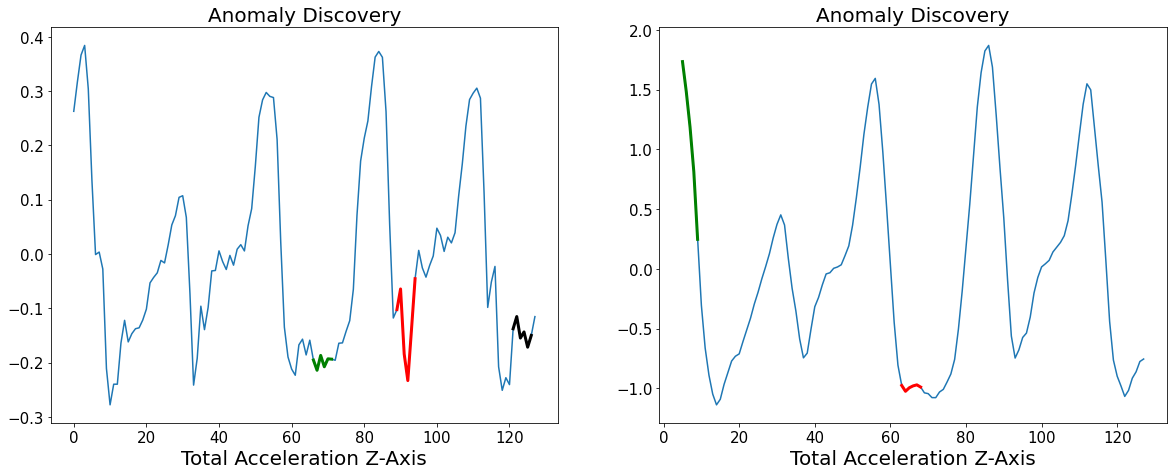

In [63]:
plt.figure(figsize=(20, 16))
plt.subplot(2,2,1)
anoms = discords(mp, ex_zone=3, k=6)
plt.plot(plotting.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = plotting.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)
    
plt.title('Anomaly Discovery', fontsize=20)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,2,2)
anoms = discords(mp2, ex_zone=3, k=6)
plt.plot(plotting2.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = plotting2.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)
    
plt.title('Anomaly Discovery', fontsize=20)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Shapelet Transform

In [64]:
X_test = Xdf_test.sample(n=number_of_records, random_state=42).values
y_test = [1 if _ == 6 else 0 for _ in y_test_multi]

X_train, X_valid, y_train, y_valid = train_test_split(ts_paa, y, test_size=0.3, random_state=0)
X_test = pd.DataFrame(paa.fit_transform(X_test).reshape(len(X_test), n_paa_segments))
X_train, X_valid, X_test = X_train.values, X_valid.values, X_test.values

In [65]:
# Shapelet transformation
st = ShapeletTransform(window_sizes=[4,12], random_state=42, sort=True)
X_train_new = st.fit_transform(X_train, y_train)
y_train_new = y_train
X_test_new = st.transform(X_test)

In [66]:
for clf in [DecisionTreeClassifier(max_depth=8, random_state=42), KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform'), KNeighborsClassifier(n_neighbors=5, metric='dtw_sakoechiba', weights='uniform')]:
    print(str(clf)[:str(clf).find('(')])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))


    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    print(auc(fpr, tpr))
    print()

DecisionTreeClassifier
Accuracy 0.9142857142857143
F1-score [0.94966443 0.71153846]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       286
           1       0.93      0.58      0.71        64

    accuracy                           0.91       350
   macro avg       0.92      0.78      0.83       350
weighted avg       0.92      0.91      0.91       350

0.7838177447552448

KNeighborsClassifier
Accuracy 0.9142857142857143
F1-score [0.95016611 0.69387755]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       1.00      0.53      0.69        64

    accuracy                           0.91       350
   macro avg       0.95      0.77      0.82       350
weighted avg       0.92      0.91      0.90       350

0.8544307255244755

KNeighborsClassifier
Accuracy 0.9142857142857143
F1-score [0.95016611 0.69387755]
              precision    recall  f1-score   support

   

In [67]:
for clf in [DecisionTreeClassifier(max_depth=8, random_state=42), KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform'), KNeighborsClassifier(n_neighbors=5, metric='dtw_sakoechiba', weights='uniform')]:
    print(str(clf)[:str(clf).find('(')])
    clf.fit(X_train_new, y_train_new)

    y_pred = clf.predict(X_test_new)
    y_score = clf.predict_proba(X_test_new)

    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))


    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])

    print(auc(fpr, tpr))
    print()

DecisionTreeClassifier
Accuracy 0.9085714285714286
F1-score [0.94594595 0.7037037 ]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       286
           1       0.86      0.59      0.70        64

    accuracy                           0.91       350
   macro avg       0.89      0.79      0.82       350
weighted avg       0.91      0.91      0.90       350

0.8306927447552447

KNeighborsClassifier
Accuracy 0.9171428571428571
F1-score [0.95174709 0.70707071]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       1.00      0.55      0.71        64

    accuracy                           0.92       350
   macro avg       0.95      0.77      0.83       350
weighted avg       0.92      0.92      0.91       350

0.9105659965034965

KNeighborsClassifier
Accuracy 0.9171428571428571
F1-score [0.95174709 0.70707071]
              precision    recall  f1-score   support

   

In [68]:
Xv = ts_paa.values

n_ts, ts_sz = Xv.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1, scale=False)

shp_clf.fit(Xv, y)

predicted_labels = shp_clf.predict(Xv)
print("Correct classification rate:", accuracy_score(y, predicted_labels))

predicted_locations = shp_clf.locate(Xv)

n_ts 350
ts_sz 15
n_classes 2
shapelet_sizes {1: 3}


/usr/local/lib/python3.7/dist-packages/tslearn/shapelets/shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


Epoch 1/200
2/2 [==============================] - 1s 9ms/step - loss: 0.6183 - binary_accuracy: 0.8886 - binary_crossentropy: 0.6105
Epoch 2/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6155 - binary_accuracy: 0.8857 - binary_crossentropy: 0.6077
Epoch 3/200
2/2 [==============================] - 0s 4ms/step - loss: 0.6126 - binary_accuracy: 0.8971 - binary_crossentropy: 0.6047
Epoch 4/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6096 - binary_accuracy: 0.9000 - binary_crossentropy: 0.6017
Epoch 5/200
2/2 [==============================] - 0s 6ms/step - loss: 0.6067 - binary_accuracy: 0.9000 - binary_crossentropy: 0.5988
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 0.6038 - binary_accuracy: 0.9029 - binary_crossentropy: 0.5958
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 0.6009 - binary_accuracy: 0.9057 - binary_crossentropy: 0.5929
Epoch 8/200
2/2 [==============================] - 0s 7ms/step

In [69]:
sorted(predicted_locations, key=lambda x: (x[0], x[1], x[2]))

[array([0, 1, 0]),
 array([0, 1, 1]),
 array([0, 1, 1]),
 array([0, 2, 0]),
 array([0, 2, 2]),
 array([0, 2, 9]),
 array([0, 3, 0]),
 array([0, 3, 3]),
 array([0, 3, 4]),
 array([0, 5, 0]),
 array([0, 5, 5]),
 array([0, 5, 5]),
 array([0, 5, 5]),
 array([0, 6, 0]),
 array([0, 6, 6]),
 array([0, 7, 0]),
 array([0, 7, 0]),
 array([0, 7, 7]),
 array([0, 8, 0]),
 array([0, 8, 8]),
 array([0, 9, 0]),
 array([0, 9, 0]),
 array([0, 9, 0]),
 array([ 0, 10,  0]),
 array([ 0, 10,  0]),
 array([ 0, 10,  0]),
 array([ 0, 10, 10]),
 array([ 0, 10, 10]),
 array([ 0, 10, 11]),
 array([ 0, 11,  0]),
 array([ 0, 11, 12]),
 array([ 0, 12,  0]),
 array([ 0, 12, 12]),
 array([ 0, 13, 13]),
 array([ 0, 13, 13]),
 array([ 0, 14, 14]),
 array([ 0, 14, 14]),
 array([1, 3, 3]),
 array([1, 4, 1]),
 array([1, 5, 5]),
 array([1, 5, 5]),
 array([1, 6, 1]),
 array([1, 7, 1]),
 array([1, 7, 7]),
 array([1, 8, 8]),
 array([1, 9, 1]),
 array([1, 9, 9]),
 array([ 1, 10,  1]),
 array([ 1, 11, 11]),
 array([ 1, 12,  1]),

In [70]:
shp_clf.shapelets_as_time_series_ 

array([[[-0.43484107]],

       [[ 1.37737703]],

       [[ 0.18553211]]])

In [71]:
t0, t0

(60, 60)

In [72]:
t0, t0 + len(shp), shp

(60, 72, array([[-0.00703044],
        [-0.08375935],
        [-0.12779286],
        [-0.15933296],
        [-0.18293069],
        [-0.20443075],
        [-0.19088148],
        [-0.15309047],
        [-0.13458153],
        [-0.08682466],
        [-0.0056634 ],
        [ 0.05716015]]))

(array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
         1.5 ]), <a list of 10 Text major ticklabel objects>)

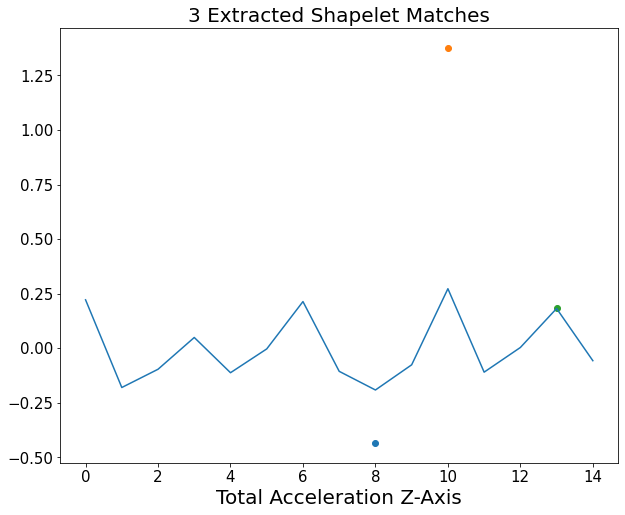

In [73]:
plt.figure(figsize=(10,8))
ts_id = 0
n_shapelets = sum(shapelet_sizes.values())
plt.title("{} Extracted Shapelet Matches".format(n_shapelets), fontsize=20)

plt.plot(Xv[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    if len(shp) > 1:
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
    else:
        plt.scatter(np.arange(t0, t0 + len(shp)), shp)
plt.xlabel('Total Acceleration Z-Axis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [74]:
st = ShapeletTransform(n_shapelets=3, window_sizes=[8])
st.fit(Xv, y)

ShapeletTransform(n_shapelets=3, window_sizes=[8])

In [75]:
len(st.shapelets_)

3

In [76]:
st.shapelets_

array([[-0.03578981,  0.03183297, -0.23891768, -0.13584601, -0.12683008,
        -0.20063716, -0.20971059, -0.03438773],
       [-0.26129004, -0.35812359, -0.17322706, -0.00975197,  0.18876371,
         0.03823781, -0.17724446, -0.219636  ],
       [ 0.11094061, -0.11048198, -0.15469542, -0.13903358, -0.19500529,
        -0.29226326, -0.08283775,  0.0219304 ]])

In [77]:
st.indices_[0]

array([54,  3, 11])

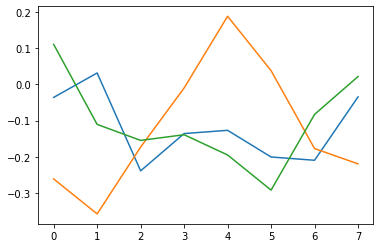

In [78]:
for idx, shape in enumerate(st.shapelets_):
    plt.plot(st.shapelets_[idx])

plt.show()

## CNN

In [79]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [80]:
print(y)

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [81]:
print(activity_label_test.values)

[5 5 5 ... 2 2 2]


Rebuilding the training and test set

In [82]:
#X_test = Xdf_test.sample(n=number_of_records, random_state=42).values
#y_test = np.array([1 if _ == 6 else 0 for _ in y_test_multi])

X_train_cnn = Xdf_train.values.reshape((Xdf_train.values.shape[0], Xdf_train.values.shape[1], 1))
X_test_cnn = Xdf_test.values.reshape((Xdf_test.shape[0], Xdf_test.shape[1], 1))

y_train_cnn = np.array([1 if lab == 6 else 0 for lab in activity_label_train.values])
y_test_cnn = np.array([1 if lab == 6 else 0 for lab in activity_label_test.values])

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train_cnn.reshape(len(y_train_cnn), 1), test_size=0.2, stratify=y_train_cnn)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  2


In [83]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [84]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 121, 16)           144       
                                                                 
 batch_normalization (BatchN  (None, 121, 16)          64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 121, 16)           0         
                                                                 
 dropout (Dropout)           (None, 121, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 117, 32)           2592      
                                                                 
 batch_normalization_1 (Batc  (None, 117, 32)          128       
 hNormalization)                                        

In [85]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [86]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=40, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/40
368/368 [==============================] - 8s 17ms/step - loss: 0.2477 - accuracy: 0.9213 - val_loss: 0.4389 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 2/40
368/368 [==============================] - 6s 15ms/step - loss: 0.1758 - accuracy: 0.9391 - val_loss: 0.2420 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 3/40
368/368 [==============================] - 6s 15ms/step - loss: 0.1758 - accuracy: 0.9381 - val_loss: 0.2729 - val_accuracy: 0.8355 - lr: 0.0010
Epoch 4/40
368/368 [==============================] - 5s 15ms/step - loss: 0.1691 - accuracy: 0.9391 - val_loss: 0.3310 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 5/40
368/368 [==============================] - 5s 15ms/step - loss: 0.1718 - accuracy: 0.9407 - val_loss: 0.2468 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 6/40
368/368 [==============================] - 6s 15ms/step - loss: 0.1668 - accuracy: 0.9415 - val_loss: 0.1991 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 7/40
368/368 [==============================] - 5s 15ms/st

In [87]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test_cnn, y_pred))
print('F1-score %s' % f1_score(y_test_cnn, y_pred, average=None))
print(classification_report(y_test_cnn, y_pred))

Accuracy 0.9209365456396336
F1-score [0.95377901 0.72684642]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2410
           1       0.98      0.58      0.73       537

    accuracy                           0.92      2947
   macro avg       0.95      0.79      0.84      2947
weighted avg       0.93      0.92      0.91      2947



In [88]:
cnn.evaluate(X_test_cnn, y_test_cnn)

93/93 [==============================] - 1s 6ms/step - loss: 0.2223 - accuracy: 0.9209


[0.22229915857315063, 0.9209365248680115]

In [89]:
history_cnn

{'accuracy': [0.9212719202041626,
  0.9391260147094727,
  0.9381057620048523,
  0.9391260147094727,
  0.9406563639640808,
  0.941506564617157,
  0.942186713218689,
  0.9403162598609924,
  0.9435470104217529,
  0.9443972110748291,
  0.9440571069717407,
  0.942866861820221,
  0.9430369138717651,
  0.9438871145248413,
  0.9433769583702087,
  0.9440571069717407,
  0.9425267577171326,
  0.9435470104217529,
  0.9416765570640564,
  0.9420166611671448,
  0.9447373151779175,
  0.9413365125656128,
  0.9423567652702332,
  0.9445672631263733,
  0.9438871145248413,
  0.9457575082778931,
  0.9443972110748291,
  0.9440571069717407,
  0.9442271590232849,
  0.9426968097686768,
  0.9445672631263733,
  0.9447373151779175,
  0.9437170624732971,
  0.942866861820221,
  0.9435470104217529,
  0.9440571069717407,
  0.9454174637794495,
  0.9460976123809814,
  0.9445672631263733,
  0.9426968097686768],
 'loss': [0.24767275154590607,
  0.1757604479789734,
  0.17577029764652252,
  0.1691461056470871,
  0.171828716

93/93 - 0s - loss: 0.2223 - accuracy: 0.9209 - 459ms/epoch - 5ms/step


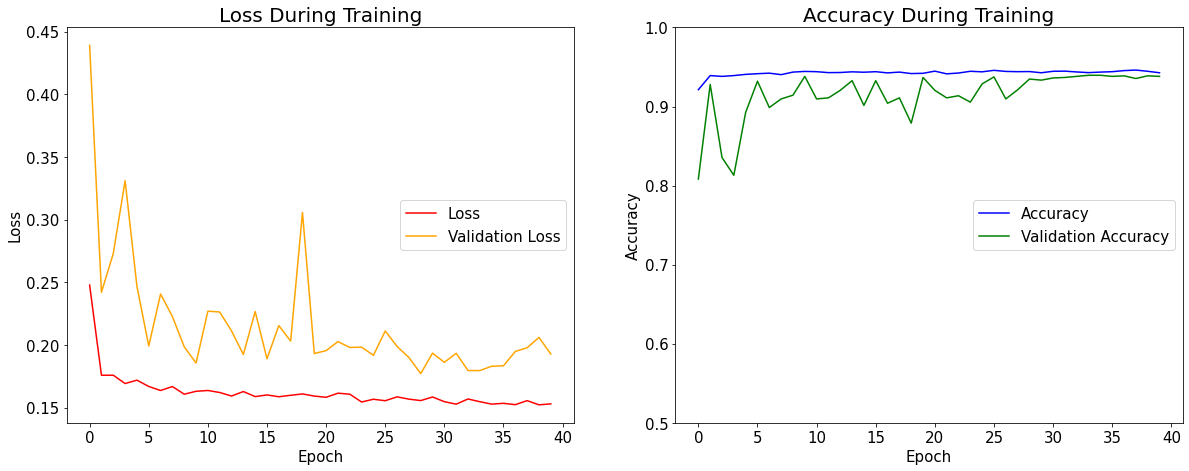

In [90]:
plt.figure(figsize=(20, 16))
plt.subplot(2,2,1)
plt.plot(history_cnn['loss'], label='Loss', c='r')
plt.plot(history_cnn['val_loss'], label = 'Validation Loss', c='orange')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc='center right', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Loss During Training', fontsize=20)

plt.subplot(2,2,2)
plt.plot(history_cnn['accuracy'], label='Accuracy', c='b')
plt.plot(history_cnn['val_accuracy'], label = 'Validation Accuracy', c='g')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim([0.5, 1])
plt.legend(loc='center right', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Accuracy During Training', fontsize=20)

test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test_cnn, verbose=2)


In [91]:
X_train_knn = Xdf_train.values
X_test_knn = Xdf_test.values

y_train_knn = np.array([1 if lab == 6 else 0 for lab in activity_label_train.values])
y_test_knn = np.array([1 if lab == 6 else 0 for lab in activity_label_test.values])

X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_train_knn, y_train_knn, test_size=0.2, stratify=y_train_knn)


for metric in ['euclidean']:
    print(metric)
    knn_clf = KNeighborsClassifier(n_neighbors=1, metric=metric)
    knn_clf.fit(X_train_knn, y_train_knn)

    y_pred = knn_clf.predict(X_test_knn)

    print('Accuracy %s' % accuracy_score(y_test_knn, y_pred))
    print('F1-score %s' % f1_score(y_test_knn, y_pred, average=None))
    print(classification_report(y_test_knn, y_pred))
    print()

euclidean
Accuracy 0.9070240922972514
F1-score [0.94437678 0.71694215]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2410
           1       0.81      0.65      0.72       537

    accuracy                           0.91      2947
   macro avg       0.86      0.81      0.83      2947
weighted avg       0.90      0.91      0.90      2947




## Mini-Rocket

In [92]:
X_train_mr = pd.DataFrame([[pd.Series(Xdf_train.values[n])] for n in range(Xdf_train.shape[0])])
X_test_mr = pd.DataFrame([[pd.Series(Xdf_test.values[n])] for n in range(Xdf_test.shape[0])])

y_train_mr = np.array([1 if lab == 6 else 0 for lab in activity_label_train.values])
y_test_mr = np.array([1 if lab == 6 else 0 for lab in activity_label_test.values])

X_train_mr, X_val_mr, y_train_mr, y_val_mr = train_test_split(X_train_mr, y_train_mr, test_size=0.2, stratify=y_train_mr)

In [93]:
minirocket = MiniRocket()  # by default, MiniRocket uses ~10,000 kernels
minirocket.fit(X_train_mr)
X_train_transform = minirocket.transform(X_train_mr)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_transform, y_train_mr)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [94]:
X_test_transform = minirocket.transform(X_test_mr)
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test_mr, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2410
           1       0.98      0.63      0.77       537

    accuracy                           0.93      2947
   macro avg       0.95      0.81      0.86      2947
weighted avg       0.93      0.93      0.92      2947



# Sequential Pattern Mining

Building a training and test set

In [95]:
df_train = df.loc[0:len(individuals_train) - 1]
Xdf_train = df_train[[x for x in df_train.columns if x not in ['label', 'individuals']]]

df_test = df.loc[len(individuals_train):]
Xdf_test = df_test[[x for x in df_test.columns if x not in ['label', 'individuals']]]

Xdf

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.102934,0.105687,0.102102,0.106553,0.102814,0.107493,0.109386,0.103886,0.102473,0.097566,...,0.100058,0.098564,0.093177,0.088742,0.090505,0.094843,0.098350,0.100385,0.099874,0.094987
1,0.097930,0.099351,0.098114,0.097517,0.097472,0.096577,0.097741,0.097309,0.098159,0.101166,...,0.094537,0.098759,0.101977,0.095360,0.089466,0.095126,0.099496,0.093535,0.089035,0.090612
2,0.091117,0.092676,0.096064,0.099897,0.097627,0.088291,0.082241,0.081100,0.081295,0.081927,...,0.085343,0.087155,0.084546,0.082166,0.081972,0.081413,0.081936,0.083011,0.082334,0.081487
3,0.095152,0.095415,0.088274,0.086325,0.088411,0.088929,0.091691,0.093365,0.096477,0.098737,...,0.088112,0.087322,0.083738,0.082701,0.084490,0.082785,0.084084,0.085761,0.083275,0.081404
4,0.080841,0.079127,0.078291,0.084063,0.089450,0.089304,0.090460,0.088985,0.087994,0.088165,...,0.088028,0.090312,0.088713,0.086957,0.086522,0.081640,0.079652,0.081329,0.085397,0.088816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,-0.247392,-0.243601,-0.292436,-0.395898,-0.421831,-0.376531,-0.393286,-0.471117,-0.537587,-0.474430,...,-0.386247,-0.358017,-0.328768,-0.343722,-0.408588,-0.402184,-0.351453,-0.330635,-0.254794,-0.229436
10295,-0.275710,-0.258489,-0.224109,-0.199280,-0.221270,-0.266509,-0.303976,-0.316916,-0.348143,-0.444931,...,-0.303917,-0.239700,-0.231936,-0.227728,-0.193037,-0.151306,-0.191359,-0.355499,-0.500135,-0.489756
10296,-0.221693,-0.204556,-0.256872,-0.284703,-0.326061,-0.332495,-0.287243,-0.269153,-0.223807,-0.222689,...,0.001781,-0.021745,-0.079452,-0.175389,-0.267170,-0.291177,-0.294972,-0.272397,-0.067734,0.137826
10297,-0.394082,-0.315110,-0.213904,-0.182951,-0.217620,-0.161440,-0.179848,-0.224930,-0.177915,-0.208381,...,-0.156169,-0.128266,-0.083245,-0.015681,-0.017426,-0.038509,0.000626,-0.003512,-0.111786,-0.276068


In [96]:
X = Xdf_train

In [97]:
scaler_MV = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler_MV.fit_transform(X.loc[X.index[0]].values.reshape(1, -1)).ravel()
for i in X.index[1:]:
    ts = np.vstack([ts, scaler_MV.fit_transform(X.loc[i].values.reshape(1, -1)).ravel()])
    
ts = pd.DataFrame(ts)
#ts = X.reset_index(drop = True) #because honestly the MeanVariance scaler lower too much the classification performances

In [98]:
# SAX transform
n_paa_segments = 10
n_sax_symbols = 20
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = pd.DataFrame(sax.fit_transform(ts).reshape(len(ts), n_paa_segments))
sax_dataset_inv = pd.DataFrame(sax.inverse_transform(ts_sax).reshape(len(X), len(X.columns)))

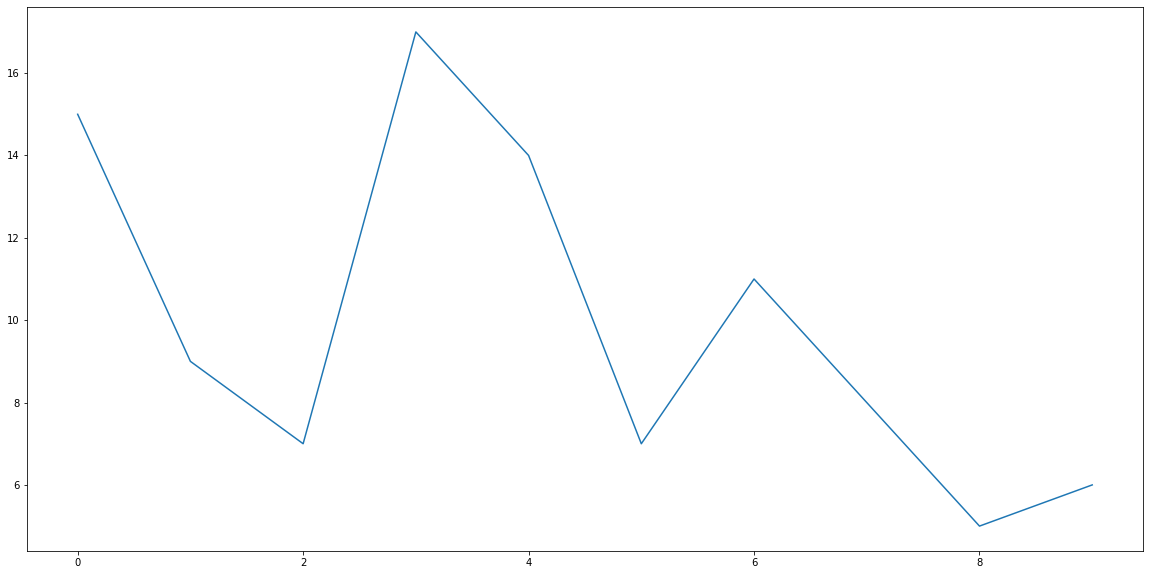

In [99]:
plt.figure(figsize=(20,10))
plt.plot(ts_sax.loc[0].ravel())
plt.show()

Text(0.5, 0.98, 'SAX, 20 Symbols Approximation (examples from subject 1)')

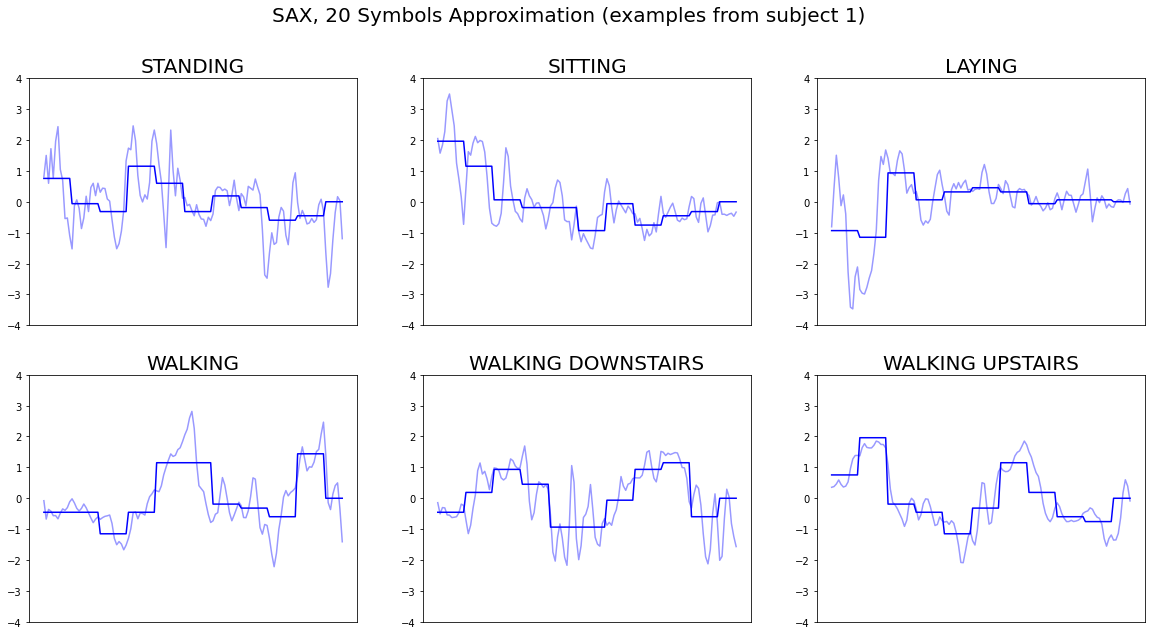

In [100]:
idxs = [df_train[df_train['label'] == label].index[0] for label in df_train['label'].unique()]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

for ax, idxs in zip([ax1,ax2,ax3,ax4,ax5,ax6], idxs):
    ax.plot(ts.loc[idxs].ravel(), "b-", alpha=0.4)
    ax.plot(sax_dataset_inv.loc[idxs].ravel(), "b-")
    ax.set_title("{}".format(df['label'].loc[idxs].replace('_', ' ')), fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    #ax.tick_params(axis='y', labelsize=20)
plt.suptitle("SAX, {} Symbols Approximation (examples from subject 1)".format(n_sax_symbols), fontsize=20)

## PrefixSpan

In [101]:
study = []
for label in [_ for _ in df_train['label'].unique()]:
    #print('##########################################\n##########################################\n',label,'\n##########################################\n##########################################\n')
    considerit = ts_sax.loc[df_train['label']==label].values
    ps = PrefixSpan(considerit)
    
    #FOR n LENGTH OF SUBSEQUENCE:
    for n in range(4):
        #print('Only subsequences greater than', n)
        freq = ps.frequent(10)

        save = []
        for el in freq:
            if len(el[1]) > n:
                save.append(el)
                
        try:
            max_supp = max([x[0] for x in save])
            #print('{} - {:.2%}'.format(max_supp, max_supp / len(considerit))
            
            condition_respected = [x[1] for x in save if x[0] == max_supp]
            study.append((label, n, max_supp, '{:.2%}'.format(max_supp / len(considerit)), condition_respected))
            #print(condition_respected)
            
        except ValueError:
            continue

In [102]:
compare_patterns = pd.DataFrame(study, columns=['label', 'subsequence_longer_than', 'abs_support', 'relative_support', 'subsequences'])
compare_patterns

,label,subsequence_longer_than,abs_support,relative_support,subsequences
0,STANDING,0,703,51.16%,[[9]]
1,STANDING,1,225,16.38%,"[[11, 10]]"
2,STANDING,2,56,4.08%,"[[7, 11, 12], [11, 10, 9]]"
3,STANDING,3,15,1.09%,"[[16, 8, 7, 5], [16, 13, 7, 3]]"
4,SITTING,0,671,52.18%,[[10]]
5,SITTING,1,220,17.11%,"[[10, 8]]"
6,SITTING,2,62,4.82%,"[[10, 10, 8]]"
7,SITTING,3,16,1.24%,"[[7, 9, 12, 12]]"
8,LAYING,0,825,58.64%,[[10]]
9,LAYING,1,301,21.39%,"[[10, 10]]"


In [103]:
compare_patterns[compare_patterns['subsequence_longer_than'] == 0]

,label,subsequence_longer_than,abs_support,relative_support,subsequences
0,STANDING,0,703,51.16%,[[9]]
4,SITTING,0,671,52.18%,[[10]]
8,LAYING,0,825,58.64%,[[10]]
12,WALKING,0,766,62.48%,[[6]]
16,WALKING_DOWNSTAIRS,0,538,54.56%,[[9]]
20,WALKING_UPSTAIRS,0,560,52.19%,[[3]]


In [104]:
compare_patterns.loc[23]['subsequences']

[[18, 5, 3, 18], [18, 3, 18, 4], [18, 4, 4, 5], [18, 6, 3, 18], [18, 7, 3, 3]]

## GSP

In [105]:
print(os.getcwd())

/content/drive/MyDrive


In [106]:
import urllib.request

opener = urllib.request.build_opener()
opener.addheaders = [('User-Agent','Mozilla/5.0')]
urllib.request.install_opener(opener)

url = 'https://www.philippe-fournier-viger.com/spmf/download-spmfjar.php'
file_name = 'spmf.jar'
#urllib.request.urlretrieve(url, file_name)
print(os.getcwd()+'/'+file_name)

/content/drive/MyDrive/spmf.jar


In [107]:
#GSP
sbmf_outputs = []
for label in [_ for _ in df_train['label'].unique()]:
    print('##########################################\n##########################################\n',label,'\n##########################################\n##########################################\n')
    considerit = ts_sax.loc[df_train['label']==label].values

    input_example_list = [[[subseq] for subseq in seq] for seq in considerit]

    spmf = Spmf("GSP", spmf_bin_location_dir=os.getcwd(),  
                input_direct=input_example_list,
                arguments=[0.005])

    spmf.run()
    output = spmf.to_pandas_dataframe()
    sbmf_outputs.append(((label, len(considerit)), output))
    print(output)
    print()

##########################################
##########################################
 STANDING 
##########################################
##########################################

>/content/drive/MyDrive/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 4220 ms
 Frequent sequences count : 8780
 Max memory (mb):112.08000946044922


             pattern  sup
0                [0]   95
1                [1]  283
2                [2]  438
3                [3]  572
4                [4]  617
...              ...  ...
8775  [18, 17, 4, 5]    7
8776  [18, 18, 3, 3]    7
8777  [18, 18, 5, 3]    8
8778  [18, 18, 5, 6]    7
8779  [18, 18, 7, 5]    7

[8780 rows x 2 columns]

##########################################
##########################################
 SITTING 
##########################################
##########################################

>/content/drive/MyDrive/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 5411 ms
 Frequent 

I rebuilt a similar table as before, just to check if they coincided

In [108]:
gsp_info = []

for label_plus_length, pattern_sup in sbmf_outputs:
    label = label_plus_length[0]
    len_to_consider = label_plus_length[1]

    pattern_sup['length'] = pattern_sup['pattern'].apply(lambda x: len(x))

    for length in sorted(np.unique(pattern_sup['length'].values)):
        support_of_length = pattern_sup[pattern_sup['length'] == length]['sup'].values
        idx_max_sup = np.argmax(support_of_length)
        gsp_info.append((label, length,  
                        support_of_length[idx_max_sup],
                         '{:.2%}'.format(support_of_length[idx_max_sup] / len_to_consider), 
                         pattern_sup[pattern_sup['length'] == length]['pattern'].values[idx_max_sup]))

In [109]:
gsp_results = pd.DataFrame(gsp_info, columns=['label', 'subseq_of_length', 'abs_support', 'relative_support', 'example_subseq_of_max_support'])
gsp_results

,label,subseq_of_length,abs_support,relative_support,example_subseq_of_max_support
0,STANDING,1,703,51.16%,[9]
1,STANDING,2,225,16.38%,"[11, 10]"
2,STANDING,3,56,4.08%,"[7, 11, 12]"
3,STANDING,4,15,1.09%,"[16, 8, 7, 5]"
4,SITTING,1,671,52.18%,[10]
5,SITTING,2,220,17.11%,"[10, 8]"
6,SITTING,3,62,4.82%,"[10, 10, 8]"
7,SITTING,4,16,1.24%,"[7, 9, 12, 12]"
8,LAYING,1,825,58.64%,[10]
9,LAYING,2,301,21.39%,"[10, 10]"
